

<b>Description of the part </b>

In this work I was looking for new features to improve model predictions. The estimation of predictions remains, as before, the metric of the Mean Absolute Error (MAE).

The next features were added:

[1.Features related to the nearest regions](#section_1)

[2.Features related to the region](#section_2)
 <ol>
  <li>Day of week - hour</li>
  <li>Day of week - month</li>
  <li>Month - hour</li>
   <li>Day of month - hour</li>
  <li>Day of month - day of week</li>
  <li>Month - day of month</li>
    </ol>
    
[3.New features from raw data](#section_3)
<ol>
  <li>Total and average number of passengers for different periods in the present and past</li>
  <li>Average trip distance</li>
  <li>Average cost of travel</li>
   <li>Percentage of providers per hour</li>
  <li>Percentage of travel fee types</li>
  <li>Percentage of travel to each region</li>
    </ol>

 [4.Traffic related features](#section_traffic)
  <ol>
<li>The whole traffic</li>
    <ol>
  <li>dayofweek-hour</li>
  <li>day-hour</li>
  <li>hour-is_month_start</li>
   <li>hour-is_quarter_start</li>
   </ol>
    
<li>North direction</li>
    <ol>
  <li>dayofweek-hour</li>
  <li>day-hour</li>
  <li>hour-is_month_start</li>
   <li>hour-is_quarter_start</li>
     </ol>  
<li>South direction</li>
    <ol>
  <li>dayofweek-hour</li>
  <li>day-hour</li>
  <li>hour-is_month_start</li>
   <li>hour-is_quarter_start</li>
    </ol>
    
<li>East direction</li>
    <ol>
  <li>dayofweek-hour</li>
  <li>day-hour</li>
  <li>hour-is_month_start</li>
   <li>hour-is_quarter_start</li>
    </ol>
    
<li>West direction</li>
    <ol>
  <li>dayofweek-hour</li>
  <li>day-hour</li>
  <li>hour-is_month_start</li>
   <li>hour-is_quarter_start</li>
    </ol>
    </ol>

[5.# The fatures related with cluster centers, airport region and bus station ](#section_clust)

<p>After mastering the new features, I started to check whether they had improved the model </p>

<p>To do this, I have conducted assessments of the added features on the five rows closest to cluster centres, training the models on April data inclusive and testing them on May. I didn’t touch the June data at all</p>

<p>I found that adding all new features to the old features simultaneously <b><i>only worsens the prediction result</i></b>.</p>

[To understand why this is happening, I conducted the following experiments with data:](#section_invest)
<ol>
  <li>Tried to activate early model interruption to prevent overfitting</li>
  <li>Studied fetures cross-correlation</li>
  <li>Tryied to reduce the number of input variables in order to get rid of multicollinearity</li>
   <li>Tryied to find optimal number of features</li>
  <li>Tryied to do feature selection for each of the 6 sub-samples (for forward forecasting from 1 to 6 days)</li>
  <li>Tryied to do sequential feature selection</li>
    </ol>
  
 <p>As a result of this work, I have come to the following conclusions:</p>
 <ol>
  <li>In new data added, there is a high multicollinearity with old features</li>
  <li>If I trained a model only on one series instead of 102, it would not be a problem, because in that case multicollinearity would only improve the predictive results, that my experiments confirmed: high performance on training data and low on test data</li>
  <li>The low test scores are explained by the fact that in this case multicollinearity leads to results with low statistical significance and every change in the features can significantly worsen the result.The features may changed in my task, because it is necessary to train models on six different samples of 102 series divided into 5 clusters. We can see below: about 80 features are stable and 30 are variable in each sample</li>
   <li>Based on these conclusions and working conditions: long series, long training times of models, limited time, I concluded that the most optimal way is to add features sequentially and observe the result, discarding the features of a worsening result. There is simply not enough time for more detailed work.</li>
  <li>The final score with  June data confirms my conclusion: it is logical to add only the features related to traffic and raw data, the combination with others only worsens the result</li>
  <li>The result: <b><i>score improvement from previous 15.05 to 14.66 </i></b> </li>
    </ol>
  

In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy import stats
import glob
from tslearn.clustering import KShape
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
%pylab inline
from sklearn.metrics import r2_score
from pandas.plotting import autocorrelation_plot
from IPython.display import Image
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from itertools import product
from datetime import datetime
import numpy as np
import calendar
from datetime import timedelta
from sklearn.model_selection import train_test_split

# разбиение на кластеры
cluster_list_0=['1075', '1076', '1077', '1125', '1126', '1127', '1131', '1132', '1179',
       '1180', '1181', '1183', '1184', '1230', '1231', '1232', '1233', '1234',
       '1235', '1279', '1280', '1281', '1282', '1283', '1284', '1285', '1286',
       '1287', '1331', '1332', '1333', '1334', '1335', '1336', '1337', '1338',
       '1382', '1383', '1384', '1385', '1386', '1434', '1684', '1734', '1783']
cluster_list_1=['1128', '1129', '1130', '1176', '1177', '1178', '1221', '1222', '1223',
       '1227', '1228', '1229', '1272', '1273', '1274', '1278', '1326', '1327',
       '1376', '1377', '1378', '1380', '1426', '1532', '1533', '1630']
cluster_list_2=['1172', '1173', '1174', '1175', '1182', '1224', '1225', '1339', '1387',
       '1388', '1389', '1390', '1431', '1435', '1436', '1437', '1438', '1439',
       '1441', '1442']
cluster_list_3=['1733', '2068', '2069', '2118', '2119', '2168']
cluster_list_4=['1480', '1482', '1483', '1530', '1580']
# наиболее типичный ряд для каждого кластера
ts_cl_0='1334'
ts_cl_1='1326'
ts_cl_2='1387'
ts_cl_3='2068'
ts_cl_4='1530'
warnings.filterwarnings('ignore')

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


At this step, I'm looking for the features to improve the score of forecasting

In [471]:
trips_2016=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_16_preprocessing/grouped_region_2016_full.csv', index_col='index')
trips_2016.index=pd.to_datetime(trips_2016.index)
trips_2015=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_15_preprocessing/grouped_region_2015_full.csv', index_col='index')
trips_2015.index=pd.to_datetime(trips_2015.index)
trips_2014=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_14_preprocessing/grouped_region_2014_full.csv', index_col='index')
trips_2014.index=pd.to_datetime(trips_2014.index)

In [472]:
trips_2016.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
index,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80,144,50,77,319,402,531,617,846,267,...,12,0,2,44,5,41,4,70,7,66
2016-01-01 01:00:00,91,211,49,134,404,420,370,453,594,224,...,29,0,5,2,2,4,0,47,1,29


In [473]:
col_list=trips_2016.columns

# Data preprocessing

In [474]:
# holydays features prerocessing
# holydays features depending on the days of the week
def date_calculate(year):
    date_list=[]
    for y,i,j in zip(usa_holidays['2020'].dt.month.tolist(),usa_holidays['number_of_week'].tolist(), usa_holidays['day_of_week'].tolist()  ):
    
        if calendar.monthcalendar(year,y)[0][j] ==0:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i+1][j])
        else:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i][j])
        date_list.append(res)
    return date_list 
# loading holyday tab from internet
base_url ='https://www.officeholidays.com/countries/usa/2020'
df_list = pd.read_html(base_url, flavor='html5lib')
usa_holidays=df_list[0]


# delete the row as it is the holiday in another state
usa_holidays=usa_holidays.drop([11])
# Add new columns for rolling holidays date transformation
usa_holidays['2020']='2020 '+usa_holidays['Date']
usa_holidays['2020']=pd.to_datetime(usa_holidays['2020']) 
usa_holidays['day_of_week']=0
usa_holidays['number_of_week']=0
#  Leave only rows with dates depending on the days of the week
criteria_1=usa_holidays.Comments.notna()
usa_holidays_1=usa_holidays[criteria_1]
list_of_days=[5,0,0,6,0,6,5,5,5,5,0,0,5,5,3,4,5,5,5]
list_of_weeks_numbers=[0,2,2,1,3,2,0,0,0,0,0,1,0,0,3,3,0,0,0]

usa_holidays.loc[:, 'day_of_week']=list_of_days
usa_holidays.loc[:, 'number_of_week']=list_of_weeks_numbers
usa_holidays['2014']=date_calculate(2014)
usa_holidays['2015']=date_calculate(2015)
usa_holidays['2016']=date_calculate(2016)
# Add the columns with other holidays 
usa_holidays['2016_2']='2016 '+usa_holidays['Date']
usa_holidays['2016_2']=pd.to_datetime(usa_holidays['2016_2'])


usa_holidays['2015_2']='2015 '+usa_holidays['Date']
usa_holidays['2015_2']=pd.to_datetime(usa_holidays['2015_2'])


usa_holidays['2014_2']='2014 '+usa_holidays['Date']
usa_holidays['2014_2']=pd.to_datetime(usa_holidays['2014_2'])
# Join dates
usa_holidays['2014'] = np.where(~criteria_1, usa_holidays['2014_2'], usa_holidays['2014'])
usa_holidays['2015'] = np.where(~criteria_1, usa_holidays['2015_2'], usa_holidays['2015'])
usa_holidays['2016'] = np.where(~criteria_1, usa_holidays['2016_2'], usa_holidays['2016'])
#  Delete temporarily used columnsи
usa_holidays=usa_holidays.iloc[:,[8,9,10]]
# Add columns with pre- and day after the holiday
delta=timedelta(days=1)
usa_holidays=usa_holidays['2014'].append(usa_holidays['2015']).append(usa_holidays['2016'])
usa_holidays=usa_holidays.to_frame(name='holidays')
usa_holidays['day_before']=usa_holidays['holidays']-delta
usa_holidays['day_after']=usa_holidays['holidays']+delta
hol_list_hol=usa_holidays.holidays.tolist()
hol_list_before=usa_holidays.day_before.tolist()
hol_list_after=usa_holidays.day_after.tolist()

## load data
def load_data(num_ts):
    grouped_index_16=trips_2016[num_ts]
    grouped_index_15=trips_2015[num_ts]
    grouped_index_14=trips_2014[num_ts]
    grouped_index_14_16=grouped_index_14\
        .append(grouped_index_15)\
        .append(grouped_index_16)
    
    grouped_index_14_16.name='Count'
    
    return grouped_index_14_16

# Check and input missing values

def data_check(series):
    date_rng = pd.date_range(start='2014-01-01', end='2016-06-30 23:00:00', freq='H')
    grouped_index_14_16_add=pd.DataFrame({'Count': 0},index=date_rng )
    series=series.sort_index()
    series=series.to_frame().append(grouped_index_14_16_add)
    grouped=series.groupby(series.index)['Count'].sum().to_frame()
    return grouped

#Find the average values and replace with them data for 2016 for the 
#observed period
def data_storm(series_2):
    list_to_change=((series_2.loc['2015-01-24 05:00:00':'2015-01-26 09:00:00'].Count.values+series_2.loc['2014-01-25 05:00:00':'2014-01-27 09:00:00'].Count.values)/2).astype('int')
    series_2.loc['2016-01-23 05:00:00':'2016-01-25 09:00:00','Count']=list_to_change
    grouped=series_2
    return grouped

# Feature mastering
## Adding holidays
def add_holidays(series_3):
    criteria_hol=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_hol)
    criteria_before=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_before)
    criteria_after=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_after)
    series_3['hol']=np.where(criteria_hol, 1, 0)
    series_3['before_hol']=np.where(criteria_before, 1, 0)
    series_3['after_hol']=np.where(criteria_after, 1, 0)
    grouped=series_3
    return grouped

## Adding intercept, day, week and year's features
def add_features(series_4):
    
   # intercept
    series_4['w_0']=1
    T=len(series_4)
    t=np.linspace(1,T, T)
    # week features
    for j in range(50):
        i=j+1
        name='sw_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/168)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cw_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/168)
        series_4[name]=new_column_values
     # year's features
    for j in range(50):
        i=j+1
        name='sy_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/8766)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cy_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/8766)
        series_4[name]=new_column_values
         # day features
    for j in range(50):
        i=j+1
        name='sh_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/24)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='ch_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/24)
        series_4[name]=new_column_values
    grouped=series_4
    return grouped
def add_traffic(series_11):
    df=series_11
    data_names=['df_A', 'df_EB', 'df_NB', 'df_SB', 'df_WB']
    res_names=['tp_dw_h', 'tp_d_h', 'tp_h_ms', 'tp_h_qs']
    for name in data_names:
        # dayofweek - hour
        file_name=name+res_names[0]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='dayofweek')
        df[name+res_names[0]]=[ts.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.hour)]
        # day - hour
        file_name=name+res_names[1]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='day')
        df[name+res_names[1]]=[ts.iloc[x,y] for x,y in zip(df.index.day-1, df.index.hour)]
        # hour - month-start
        file_name=name+res_names[2]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='hour')
        df[name+res_names[2]]=[ts.iloc[x,y] for x,y in zip(df.index.hour, df.index.is_month_start*1)]
        # hour - quartal-start
        file_name=name+res_names[3]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='hour')
        df[name+res_names[3]]=[ts.iloc[x,y] for x,y in zip(df.index.hour, df.index.is_quarter_start*1)]
    grouped=df
    return grouped  

def add_rawdata_features(series_10):
    file_name=num_ts+'_df'+'.csv'
    series=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/Time_series_2//'+file_name, index_col=0)
    series=series.drop('Count', axis=1)
    groupped=series_10.join(series)
    
    return groupped
# adding cluster features
def add_cluster(series_12):
    reg_list=['2069', '2119', '1182', '1334', '1326', '1387', '2068', '1530']
    ## defining if the current time series is in the list and if in - delete
    cofirmed_lst=[x for x in reg_list if x != num_ts]
    for num_ts_add in cofirmed_lst:
        # adding the distance between time series
        ts=quick_preprocessing(num_ts)
        ts_add=quick_preprocessing(num_ts_add)
        series=ts-ts_add
        name=num_ts_add+'_add'
        series_12[name]=series
        # adding the number of passengers
        file_name=num_ts_add+'_df'+'.csv'
        series=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/Time_series_2//'+file_name, index_col=0)
        series=series[series.columns[pd.Series(series.columns).str.startswith('passenger')]].add_suffix(num_ts_add)
        series_12=series_12.join(series)
    groupped=series_12
    return groupped

## selecting the most important features## Отбор важных признаков
def feature_selection(series_5, num_features):
    
    x=series_5.loc[:'2016.04.30 23:00','hol':]
    y=np.array(series_5.loc[:'2016.04.30 23:00','Count']).reshape(-1)
    #apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=num_features)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    return grouped

def feature_selection_2(series_5, num_features2):
    cols = series_5.columns.drop('Count')
    X = series_5[cols].loc[:'2016-04-30 23:00',:]
    Y=np.array(series_5.loc[:'2016-04-30 23:00','Count']).reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, 
                                                        random_state=7)
    param=[0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01]
    xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
    eval_set = [(X_test, y_test)]
    xgb.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="mae",
            eval_set=eval_set, verbose=False)
    xgb.get_booster().get_score(importance_type='weight')
    
    dfscores = pd.DataFrame(xgb.feature_importances_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features2,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    return grouped
    




## splitting data for training and testing sets
def split_data(series_6):
    
    ## intervals till the end of april
    train_sarimax=series_6.loc[:'2016-04-30 23:00']
    x_train_sarimax=train_sarimax.iloc[:,1:]
    y_train_sarimax=train_sarimax.iloc[:,0]
    
     ## intervals till the end of juneя
    train=series_6.loc[:'2016-06-30 23:00']
    x_train=train.iloc[:,1:]
    y_train=train.iloc[:,0]

     ## test sample
    test=series_6.loc['2016-05-01':]
    return x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax

# Combining all
def data_preprocessing(num_ts, num_features):
    warnings.filterwarnings('ignore')
    grouped=load_data(num_ts)
    grouped=data_check(grouped)
    grouped= data_storm(grouped)
    grouped=add_holidays(grouped)
    grouped=add_features(grouped)
    # добавляю траффик
    #grouped=add_traffic(grouped)
    # добавляю сырые данные
    #grouped=add_rawdata_features(grouped)
    grouped=feature_selection(grouped, num_features)
    x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax =split_data(grouped)
    return grouped,  x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax
                              
# preprocessing without adding features

def quick_preprocessing(num_ts):
    df=load_data(num_ts)
    df=data_check(df)
    df=data_storm(df)
    return df   

In [475]:
def data_preprocessing_stage_2(num_ts,num_features):
     # Adding SARIMA predictions as new features
    series_7=data_preprocessing(num_ts, num_features)
    df=series_7[0]
    f_name=num_ts+'_sarima'+'.csv'
    sarima_features=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W5/Step_2_create_ARIMA_feat/'+f_name, index_col='id')
    sarima_features.index=pd.to_datetime(sarima_features.index)
    df=df.assign(sarima=sarima_features.sarima)
    # Adding new features depending from data
    # year's features
    df=df.assign(y_f=df.index.year-2014)
    # month's features
    df=df.assign(mnth_sin=(np.sin((df.index.month-1)*(2.*np.pi/12))))
    df=df.assign(mnth_cos=(np.cos((df.index.month-1)*(2.*np.pi/12))))
    # day's features
    df=df.assign(d_f=df.index.day)
    # hour's feature
    df= df.assign(hr_sin=np.sin(df.index.hour*(2.*np.pi/24)))
    df= df.assign(hr_cos=np.cos(df.index.hour*(2.*np.pi/24)))
    # the number of day in the year
    df=df.assign(yd_f=df.index.dayofyear)
    # the number of week in the year
    df=df.assign(wk_f=df.index.weekofyear)
    # day of week
    df=df.assign(wd_sin=np.sin(df.index.dayofweek*(2.*np.pi/7)))
    df=df.assign(wd_cos=np.cos(df.index.dayofweek*(2.*np.pi/7)))
    # check is this a start of the month
    df=df.assign(ms_f=df.index.is_month_start*1)
    # check is this a start of the quarter
    df=df.assign(qs_f=df.index.is_quarter_start*1)
    # the number of quarter
    df=df.assign(qs_sin=np.sin((df.index.quarter-1)*(2.*np.pi/4)))
    df=df.assign(qs_cos=np.cos((df.index.quarter-1)*(2.*np.pi/4)))
    # summary and avarege number of travels for 12 hours, 24 hours and etc.
    df=df.assign(rol_12s=df.Count.rolling(12).sum())
    df=df.assign(rol_24s=df.Count.rolling(24).sum())
    df=df.assign(rol_168s=df.Count.rolling(168).sum())
    df=df.assign(rol_720s=df.Count.rolling(720).sum())
    df=df.assign(rol_12m=df.Count.rolling(12).mean())
    df=df.assign(rol_24m=df.Count.rolling(24).mean())
    df=df.assign(rol_168m=df.Count.rolling(168).mean())
    df=df.assign(rol_720m=df.Count.rolling(720).mean())
    # the number of trips in the past
    tdelta=timedelta(hours=1)
    K=24
    for j in range(K):
        i=j+1
        name='shift_H'+str(i)
        new_column_values=df.Count.shift(i)
        df[name]=new_column_values
    # 
    tdelta=timedelta(hours=1)
    Kd=20
    for j in range(Kd):
        i=j+1
        name='shift_D'+str(i)
        new_column_values=df.Count.shift(i*24)
        df[name]=new_column_values
    #One hot encoding for clusters
    oh_0=int(num_ts in cluster_list_0)
    oh_1=int(num_ts in cluster_list_1)
    oh_2=int(num_ts in cluster_list_2)
    oh_3=int(num_ts in cluster_list_3)
    oh_4=int(num_ts in cluster_list_4)
    df=df.assign(oh_0=oh_0,
            oh_1=oh_1,
            oh_2=oh_2,
            oh_3=oh_3,
            oh_4=oh_4)
    
    # adding traffic
    df=add_traffic(df)
    # adding raw data new features
    df=add_rawdata_features(df)
    # adding distance to clusters
    #df=add_cluster(df)
    
    
    
    
    df=df.dropna()
    # sample till the end of april
    df_a=df[:'2016-04-30 23:00:00']
    # sample till the end of may
    df_m=df[:'2016-05-31 23:00:00']
    #complite sample
    df_j=df[:'2016-06-30 23:00:00']
     # Creating samples for 1-6 hours forecasting in feature
    sample_1=df_j
    shift_1=sample_1.Count.shift(-1)
    sample_1.Count=shift_1
    
    sample_2=sample_1.dropna()
    shift_2=sample_2.Count.shift(-1)
    sample_2.Count=shift_2
    
    sample_3=sample_2.dropna()
    shift_3=sample_3.Count.shift(-1)
    sample_3.Count=shift_3

    sample_4=sample_3.dropna()
    shift_4=sample_4.Count.shift(-1)
    sample_4.Count=shift_4

    sample_5=sample_4.dropna()
    shift_5=sample_5.Count.shift(-1)
    sample_5.Count=shift_5

    sample_6=sample_5.dropna()
    shift_6=sample_6.Count.shift(-1)
    sample_6.Count=shift_6
    
    
    return df_a, sample_1, sample_2, sample_3, sample_4, sample_5, sample_6, df_m, df_j, df

<a id='section_1'></a>
# Creating features concerning with the nearest regions

First of all, trying to use the distance to the time series in the nearest regions. Used 1180 region as a pattern.

In [39]:
num_ts='1180'
num_features=160
column_list=trips_2016.columns
int_num=int(num_ts)
neighbor_list=[int_num-50,int_num+50,int_num-49, int_num+1, int_num+51, int_num-51, int_num-1, int_num+49]
series_8=data_preprocessing(num_ts, num_features)
df=series_8[0]
for neighbor in neighbor_list:
        # проверяю существует ли такой сосед в списке из 102 регионов
        neighbor=str(neighbor)
        if neighbor in column_list:
            ts=quick_preprocessing(num_ts)
            neighbor_ts=quick_preprocessing(neighbor)
            series=ts-neighbor_ts
            name=neighbor+'_n'
            df[name]=series

In [45]:
df.head(2)

,Count,after_hol,before_hol,ch_1,ch_15,ch_16,ch_18,ch_19,ch_2,ch_20,...,sy_50,sy_9,1130_n,1230_n,1131_n,1181_n,1231_n,1129_n,1179_n,1229_n
2014-01-01 00:00:00,1198,0,0,0.965926,-7.071068e-01,-0.5,-1.836970e-16,0.258819,0.866025,0.5,...,0.035831,0.006451,250,-382,877,414,-102,399,363,72
2014-01-01 01:00:00,791,0,0,0.866025,1.194340e-15,-0.5,-1.000000e+00,-0.866025,0.500000,-0.5,...,0.071615,0.012901,124,-685,566,-37,3,156,156,-328


Combining all actions into the function:

In [29]:
def calc_neighbor(series_8):
    column_list=trips_2016.columns
    int_num=int(num_ts)
    neighbor_list=[int_num-50,int_num+50,int_num-49, int_num+1, int_num+51, int_num-51, int_num-1, int_num+49]
    
    for neighbor in neighbor_list:
            # проверяю существует ли такой сосед в списке из 102 регионов
            neighbor=str(neighbor)
            if neighbor in column_list:
                ts=quick_preprocessing(num_ts)
                neighbor_ts=quick_preprocessing(neighbor)
                series=ts-neighbor_ts
                name=neighbor+'_n'
                series_8[name]=series
    return series_8
    

<a id='section_2'></a>
# Features related to the region


Trying to find features related to the region’s internal infrastructure: working hours, night clubs, sights. In order not to study each region separately, one can see if there are patterns associated with its internal structure. For this purpose, it is easier to study heatmaps of regions.

 Used 1180 region as a pattern

In [7]:
num_ts='1180'
num_features=160
# load data
ts=quick_preprocessing(num_ts)
# adding fetures related to time
ts=ts.assign(dayofweek=ts.index.dayofweek)
ts=ts.assign(hour=ts.index.hour)
ts=ts.assign(month=ts.index.month)
ts=ts.assign(day=ts.index.day)

ts_mj=ts['2014-01-01 00:00:00':'2016-04-30 23:00:00']


In [8]:
ts_mj

,Count,dayofweek,hour,month,day
2014-01-01 00:00:00,1198,2,0,1,1
2014-01-01 01:00:00,791,2,1,1,1
2014-01-01 02:00:00,519,2,2,1,1
2014-01-01 03:00:00,469,2,3,1,1
2014-01-01 04:00:00,432,2,4,1,1
...,...,...,...,...,...
2016-04-30 19:00:00,984,5,19,4,30
2016-04-30 20:00:00,956,5,20,4,30
2016-04-30 21:00:00,940,5,21,4,30
2016-04-30 22:00:00,862,5,22,4,30


## Consider the first heat map: Day of the Week - Hour

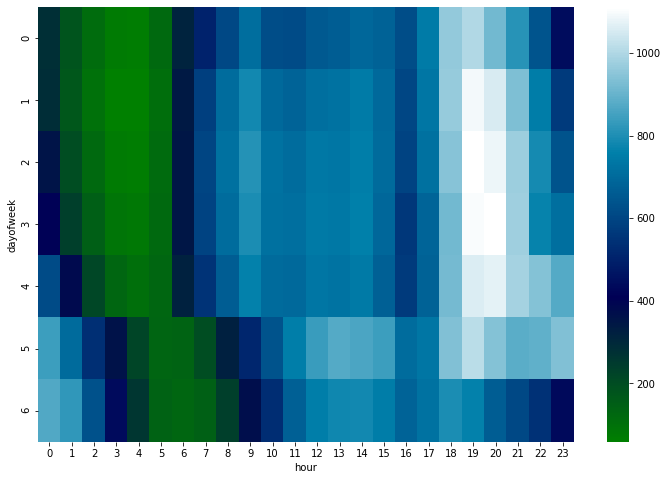

In [9]:
tp= ts_mj.pivot_table(index='dayofweek', columns='hour',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

You can see that there is a pattern: there are hours of less travel, some more. I call it the density of travel. The absolute values of these densities can be seen in the following table:

In [10]:
tp

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
dayofweek,,,,,,,,,,,,,,,,,,,,,
0,284.214876,178.900826,114.355372,72.561983,70.991736,123.066116,316.305785,506.057851,608.057851,709.438017,...,693.330579,676.330579,619.776860,748.404959,959.702479,1003.396694,914.429752,811.495868,641.867769,443.677686
1,285.404959,169.900826,103.404959,62.768595,58.685950,111.776860,342.099174,583.768595,704.842975,786.404959,...,748.462810,698.214876,602.669421,733.099174,964.768595,1093.223140,1055.586777,933.140496,753.123967,568.636364
2,358.516393,200.327869,120.385246,74.467213,69.081967,117.762295,350.377049,597.918033,717.877049,807.622951,...,756.647541,702.754098,596.729508,717.418033,946.352459,1111.303279,1086.500000,972.844262,790.540984,638.213115
3,415.729508,237.639344,152.155738,90.393443,81.196721,123.385246,347.032787,595.598361,705.663934,795.631148,...,761.344262,693.401639,562.450820,684.877049,916.254098,1101.868852,1109.532787,977.475410,768.090164,716.549180
4,616.680328,380.721311,218.491803,129.196721,105.418033,128.786885,321.778689,551.377049,665.680328,763.606557,...,741.409836,674.647541,568.754098,678.778689,918.155738,1058.942623,1070.360656,984.852459,941.327869,876.122951
5,841.426230,702.622951,535.737705,359.172131,221.909836,132.819672,138.786885,200.614754,322.081967,514.114754,...,864.549180,841.147541,704.237705,734.598361,936.918033,1015.098361,939.016393,882.819672,890.688525,935.188525
6,871.586777,824.239669,630.752066,438.743802,260.694215,142.462810,128.719008,148.983471,237.553719,372.223140,...,784.884298,752.132231,682.553719,723.355372,794.983471,763.851240,666.818182,606.264463,545.900826,434.818182


It is quite logical to create a property where each hour will match the density from the table

Consider other time pairs

## Day of week - month

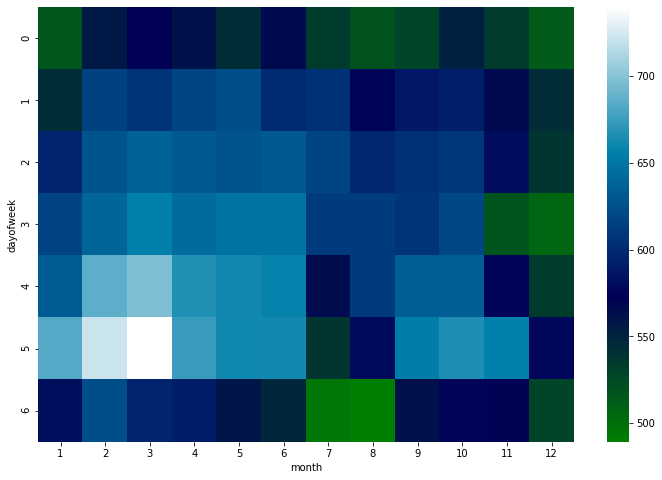

In [11]:
tp= ts_mj.pivot_table(index='dayofweek', columns='month',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

## Month - hour

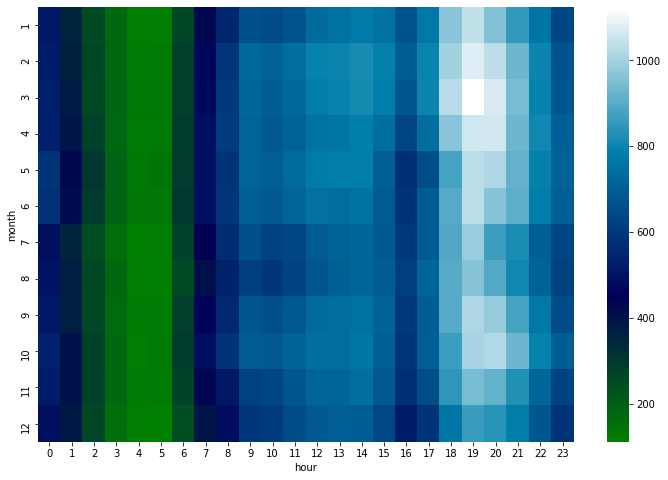

In [12]:
tp= ts_mj.pivot_table(index='month', columns='hour',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

## Day of month - hour

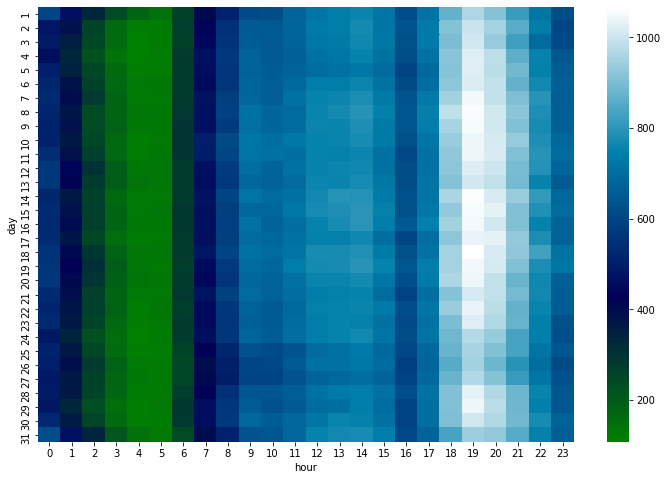

In [13]:
tp= ts_mj.pivot_table(index='day', columns='hour',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

## Day of month - day of week

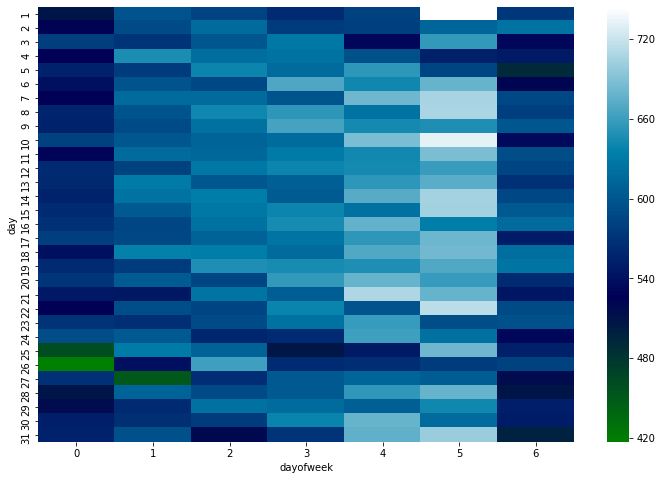

In [14]:
tp= ts_mj.pivot_table(index='day', columns='dayofweek',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

## Month - day of month

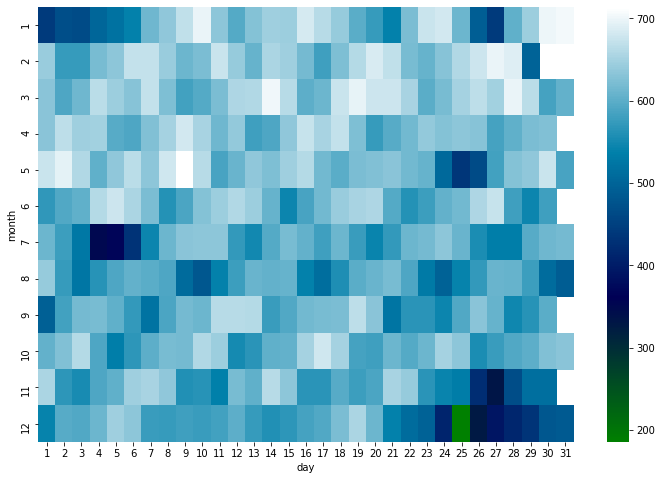

In [15]:
tp= ts_mj.pivot_table(index='month', columns='day',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

## Feature mastering

In [43]:
num_ts='1180'
num_features=160
# загрузка данных
ts=quick_preprocessing(num_ts)
# добавляю признаки связанные со временем: день недели, час суток, месяц, день месяца
ts=ts.assign(dayofweek=ts.index.dayofweek)
ts=ts.assign(hour=ts.index.hour)
ts=ts.assign(month=ts.index.month)
ts=ts.assign(day=ts.index.day)
# ограничу выборку данными до апреля 2016 года включительно
ts_mj=ts['2014-01-01 00:00:00':'2016-04-30 23:00:00']
series_9=data_preprocessing(num_ts, num_features)
df=series_9[0]
# dayofweek-month
tp= ts_mj.pivot_table(index='dayofweek', columns='month',values='Count') 
df=df.assign(dw_m_3=[tp.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.month-1)])
# dayofweek-hour
tp= ts_mj.pivot_table(index='dayofweek', columns='hour',values='Count') 
df=df.assign(dw_h_3=[tp.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.hour)])
# month - hour
tp= ts_mj.pivot_table(index='month', columns='hour',values='Count') 
df=df.assign(m_h_3=[tp.iloc[x,y] for x,y in zip(df.index.month-1, df.index.hour)])
# day - hour
tp= ts_mj.pivot_table(index='day', columns='hour',values='Count') 
df=df.assign(d_h_3=[tp.iloc[x,y] for x,y in zip(df.index.day-1, df.index.hour)])

# day - dayofweek
tp= ts_mj.pivot_table(index='day', columns='dayofweek',values='Count') 
df=df.assign(d_dw_3=[tp.iloc[x,y] for x,y in zip(df.index.day-1, df.index.dayofweek)])

# month - day
tp= ts_mj.pivot_table(index='month', columns='day',values='Count') 
df=df.assign(m_d_3=[tp.iloc[x,y] for x,y in zip(df.index.month-1, df.index.day-1)])

Combining all actions into the function:

In [55]:
def add_heat_features(series_9):
    # загрузка данных
    ts=quick_preprocessing(num_ts)
    # добавляю признаки связанные со временем: день недели, час суток, месяц, день месяца
    ts=ts.assign(dayofweek=ts.index.dayofweek)
    ts=ts.assign(hour=ts.index.hour)
    ts=ts.assign(month=ts.index.month)
    ts=ts.assign(day=ts.index.day)
    # ограничу выборку данными до апреля 2016 года включительно
    ts_mj=ts['2014-01-01 00:00:00':'2016-04-30 23:00:00']
    
    
    df=series_9
    
    # dayofweek-month
    tp= ts_mj.pivot_table(index='dayofweek', columns='month',values='Count') 
    df=df.assign(dw_m_3=[tp.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.month-1)])
    # dayofweek-hour
    tp= ts_mj.pivot_table(index='dayofweek', columns='hour',values='Count') 
    df=df.assign(dw_h_3=[tp.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.hour)])
    # month - hour
    tp= ts_mj.pivot_table(index='month', columns='hour',values='Count') 
    df=df.assign(m_h_3=[tp.iloc[x,y] for x,y in zip(df.index.month-1, df.index.hour)])
    # day - hour
    tp= ts_mj.pivot_table(index='day', columns='hour',values='Count') 
    df=df.assign(d_h_3=[tp.iloc[x,y] for x,y in zip(df.index.day-1, df.index.hour)])

    # day - dayofweek
    tp= ts_mj.pivot_table(index='day', columns='dayofweek',values='Count') 
    df=df.assign(d_dw_3=[tp.iloc[x,y] for x,y in zip(df.index.day-1, df.index.dayofweek)])

    # month - day
    tp= ts_mj.pivot_table(index='month', columns='day',values='Count') 
    df=df.assign(m_d_3=[tp.iloc[x,y] for x,y in zip(df.index.month-1, df.index.day-1)])
    
    grouped=df
    
    return grouped

<a id='section_3'></a>
# New features from raw data

Now, to prepare the features from the raw data, I will first select them and save them to the disk to speed up their extraction.

The new features will include:
    - total and average number of passengers for different periods in the present and past
    - average trip distance
    - average cost of travel
    - percentage of providers per hour
    - percentage of travel fee types
    - percentage of travel to each region
    
Since there are so many regions (about 2,000) where the average travel takes place, I will divide New York into an additional 100 regions combining the starting points, and I will calculate the shares for them.

In [17]:
def find_region(longitude,latitude):
    min_long=regions['east'].min()
    max_long=regions['east'].max()
    min_lat=regions['north'].min()
    max_lat=regions['north'].max()
    if type(longitude) != list:
        x=[]
        y=[]
        x.append(longitude)
        y.append(latitude)
        longitude=x
        latitude=y
    binx = np.linspace(min_long, max_long, 10) 
    biny = np.linspace(min_lat, max_lat, 10)
    ret = stats.binned_statistic_2d(longitude,latitude, None, 'count', bins=[binx,biny], expand_binnumbers=True)
    return  ret.binnumber[0]*6+ret.binnumber[1]+1

In [18]:
def raw_data_preprocessing(num_ts):
    num_ts=num_ts
    df=quick_preprocessing(num_ts)
    print('Start:', datetime.now().strftime("%H:%M:%S"))
    file_name_r=num_ts+'_ts'+'.csv'
    ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/Time_series//'+file_name_r, index_col='index')
    ts.index=pd.to_datetime(ts.index)
    ts=ts.sort_index()
    # average number of passengers
    ts_=ts.groupby(ts.index)['passenger_count'].mean()
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(12).sum().groupby(ts.index).mean()
    ts_.name='passenger_count_12_m'
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(24).sum().groupby(ts.index).mean()
    ts_.name='passenger_count_24_m'
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(168).sum().groupby(ts.index).mean()
    ts_.name='passenger_count_168_m'
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(720).sum().groupby(ts.index).mean()
    ts_.name='passenger_count_720_m'
    df=df.join(ts_)
    # total number of passengers
    ts_=ts['passenger_count'].rolling(12).sum().groupby(ts.index).sum()
    ts_.name='passenger_count_12_s'
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(24).sum().groupby(ts.index).sum()
    ts_.name='passenger_count_24_s'
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(168).sum().groupby(ts.index).sum()
    ts_.name='passenger_count_168_s'
    df=df.join(ts_)

    ts_=ts['passenger_count'].rolling(720).sum().groupby(ts.index).sum()
    ts_.name='passenger_count_720_s'
    df=df.join(ts_)
    # avarage distance
    ts_=ts.groupby(ts.index)['trip_distance'].mean()
    df=df.join(ts_)
    # avarage travel fee
    ts_=ts.groupby(ts.index)['total_amount'].mean()
    df=df.join(ts_)


    # percentage of providers per hour
    ts['VendorID'] = np.where(ts['VendorID'] =='CMT',
        1, 2)
    ts['VendorID']=ts['VendorID']-1
    ts_=ts.groupby(ts.index)['VendorID'].mean()
    df=df.join(ts_)

    # percentage of travel fee types
    cond_1=ts['payment_type'] =='CRD'
    cond_2=ts['payment_type'] =='1.0'
    cond_3=ts['payment_type'] ==1.0
    condition=cond_1 | cond_2 |cond_3
    ts['CRD']=np.where(condition, 1,0)
    cond_1=ts['payment_type'] =='CSH'
    cond_2=ts['payment_type'] =='2.0'
    cond_3=ts['payment_type'] ==2.0
    condition=cond_1 | cond_2 |cond_3
    ts['CSH']=np.where(condition, 1,0)
    cond_1=ts['payment_type'] =='NOC'
    cond_2=ts['payment_type'] =='3.0'
    cond_3=ts['payment_type'] ==3.0
    condition=cond_1 | cond_2 |cond_3
    ts['NOC']=np.where(condition, 1,0)
    cond_1=ts['payment_type'] =='DIS'
    cond_2=ts['payment_type'] =='4.0'
    cond_3=ts['payment_type'] ==4.0
    condition=cond_1 | cond_2 |cond_3
    ts['DIS']=np.where(condition, 1,0)
    ts_=ts.groupby(ts.index)['CRD'].mean()
    df=df.join(ts_)
    ts_=ts.groupby(ts.index)['CSH'].mean()
    df=df.join(ts_)
    ts_=ts.groupby(ts.index)['NOC'].mean()
    df=df.join(ts_)
    ts_=ts.groupby(ts.index)['DIS'].mean()
    df=df.join(ts_)
    regions=pd.read_csv('regions.csv', sep=(';'))
    ts=ts[['dropoff_longitude', 'dropoff_latitude']]
   
    # percentage of travel to each region
    longitude = ts['dropoff_longitude'].to_list()
    latitude = ts['dropoff_latitude'].to_list()
    result=find_region(longitude,latitude)
    ts['region']=result
    reg_list=list(ts.region.unique())

    for region_num in reg_list:
        condition=ts.region==region_num
        ts[str(region_num)]=np.where(condition, 1,0)
        ts_=ts.groupby(ts.index)[str(region_num)].mean()
        df=df.join(ts_)
        ts=ts.drop(str(region_num), axis=1)
        
    df.fillna(df.mean(), inplace=True)
    file_name=num_ts+'_df'+'.csv'
    df.to_csv('D:\Asus\Work_DATA\Taxi\C6W6\Time_series_2\\'+file_name, sep = ',')
    
    

    print('Посчитан ряд: ', num_ts, datetime.now().strftime("%H:%M:%S"))
    

In [26]:
filenames = sorted(glob.glob('D:\Asus\Work_DATA\Taxi\C6W6\Time_series\*.csv'))
test_names=[x[-11:-7] for x in filenames]
regions=pd.read_csv('regions.csv', sep=(';'))
for num_ts in test_names:
    raw_data_preprocessing(num_ts)
    

Start: 06:17:23
Посчитан ряд:  1075 06:17:49
Start: 06:17:49
Посчитан ряд:  1076 06:18:40
Start: 06:18:40
Посчитан ряд:  1077 06:19:16
Start: 06:19:16
Посчитан ряд:  1125 06:19:45
Start: 06:19:45
Посчитан ряд:  1126 06:20:59
Start: 06:20:59
Посчитан ряд:  1127 06:22:47
Start: 06:22:47
Посчитан ряд:  1128 06:24:48
Start: 06:24:48
Посчитан ряд:  1129 06:27:04
Start: 06:27:04
Посчитан ряд:  1130 06:29:47
Start: 06:29:47
Посчитан ряд:  1131 06:30:44
Start: 06:30:44
Посчитан ряд:  1132 06:31:05
Start: 06:31:05
Посчитан ряд:  1172 06:31:09
Start: 06:31:09
Посчитан ряд:  1173 06:31:19
Start: 06:31:19
Посчитан ряд:  1174 06:31:32
Start: 06:31:32
Посчитан ряд:  1175 06:31:38
Start: 06:31:38
Посчитан ряд:  1176 06:31:48
Start: 06:31:48
Посчитан ряд:  1177 06:33:37
Start: 06:33:38
Посчитан ряд:  1178 06:36:37
Start: 06:36:37
Посчитан ряд:  1179 06:39:56
Start: 06:39:57
Посчитан ряд:  1180 06:43:41
Start: 06:43:41
Посчитан ряд:  1181 06:48:14
Start: 06:48:15
Посчитан ряд:  1182 06:51:02
Start: 06:

Combining all actions into the function:

In [89]:

def add_rawdata_features(series_10):
    file_name=num_ts+'_df'+'.csv'
    series=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/Time_series_2//'+file_name, index_col=0)
    series=series.drop('Count', axis=1)
    groupped=series_10.join(series)
    
    return groupped
    
    

# Model comparison

At this step I will train the models on the features prepared in the previous stage and on the added new ones. I will train models  on the five samples of data - each of which is the center of the cluster. The training samples will be till the end of April and evaluate a model on the May data.

The cluster centers: 1334, 1326, 1387, 2068, 1530

In [138]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2(num_ts,260)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] 
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
        

First of all, calculating MAE on training dataset from the previous step

In [103]:

Q_may1=0

Q_june1=0

answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры

n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')


for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    
    answer1=answer1.append(series)
        
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))

    


answer1.index.name='id'
answer1.name='y'    


print('The end', datetime.now().strftime("%H:%M:%S"))

print(answer1.head())

Start: 10:44:06
Посчитан ряд  1334  за май и июнь 10:49:54
Посчитан ряд  1326  за май и июнь 10:55:27
Посчитан ряд  1387  за май и июнь 11:00:56
Посчитан ряд  2068  за май и июнь 11:06:55
Посчитан ряд  1530  за май и июнь 11:12:48
The end 11:12:48
id
1334_2016-05-31_23_1    84.794296
1334_2016-05-31_23_2    40.215412
1334_2016-05-31_23_3    26.506727
1334_2016-05-31_23_4    14.081639
1334_2016-05-31_23_5    25.002682
Name: y, dtype: float64


In [104]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  14.35297492702345
Ошибка за июнь:  12.732744256096845


Now, calculating MAE on training dataset with added new features

In [109]:
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())

Start: 11:23:08
Посчитан ряд  1334  за май и июнь 11:29:56
Посчитан ряд  1326  за май и июнь 11:35:38
Посчитан ряд  1387  за май и июнь 11:41:13
Посчитан ряд  2068  за май и июнь 11:47:30
Посчитан ряд  1530  за май и июнь 11:52:55
The end 11:52:55
id
1334_2016-05-31_23_1    82.505981
1334_2016-05-31_23_2    40.276592
1334_2016-05-31_23_3    38.756626
1334_2016-05-31_23_4    17.873343
1334_2016-05-31_23_5    26.671139
Name: y, dtype: float64


In [110]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  15.036477825573874
Ошибка за июнь:  14.07728370735278


Conclusion: unfortunately, the result on the old data was better.

Next, I’m trying to figure out why.

# Dependency of MAE on number of features

At this stage, analyze how MAE changes according to the features included in the existing feature selection system.

In [ ]:
num_ts='1231'
param=[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01]
num_features=100
print('Start:', datetime.now().strftime("%H:%M:%S"))
for i in range(20):
    num_features=20
    num_features=num_features+10*(i)
    grouped=data_preprocessing_stage_2_2(num_ts, num_features)
    grouped_=grouped[0].drop('Count', axis=1)
    X_train=grouped_.loc[:'2016.04.30 23:00',:]
    y_train=np.array(grouped[0].loc[:'2016.04.30 23:00','Count']).reshape(-1)
    # split data into train and test sets
    X_test= grouped[7].drop('Count', axis=1).loc['2016.05.01 00:00':'2016.05.31 23:00',:]
    y_test=np.array(grouped[7].loc['2016.05.01 00:00':'2016.05.31 23:00','Count']).reshape(-1)
    # fit model on all training data
    model = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
    model.fit(X_train, y_train)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(num_features, "MAE: ", mae,datetime.now().strftime("%H:%M:%S"))
    

   You can see here that the accuracy varies roughly the same with the number of features between 40 and 210. I’m trying to test this on real data, again in the five previously selected regions on data trained through April.

In [11]:
# Results: (feature types- the number of features- MAE for May - MAE for June)
dat={'feat_type':['new', 'new', 'new', 'new', 'old'],
        'feat':[40, 80,160,260,260],
        'mae_m':[15.46, 14.06, 13.57, 13.45, 14.39],
        'mae_j':[15.22, 14.17, 13.14, 12.99, 12.74]}
table_1=pd.DataFrame(dat) 
table_1

,feat_type,feat,mae_m,mae_j
0,new,40,15.46,15.22
1,new,80,14.06,14.17
2,new,160,13.57,13.14
3,new,260,13.45,12.99
4,old,260,14.39,12.74


Not much clarity emerged

In [34]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,40)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 21:52:08
Посчитан ряд  1334  за май и июнь 21:55:41
Посчитан ряд  1326  за май и июнь 21:58:58
Посчитан ряд  1387  за май и июнь 22:02:37
Посчитан ряд  2068  за май и июнь 22:06:14
Посчитан ряд  1530  за май и июнь 22:09:34
The end 22:09:34
id
1334_2016-05-31_23_1    79.401695
1334_2016-05-31_23_2    34.751629
1334_2016-05-31_23_3    18.173710
1334_2016-05-31_23_4    15.703856
1334_2016-05-31_23_5    27.423439
Name: y, dtype: float64


In [36]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  15.465246035561254
Ошибка за июнь:  15.226044203079109


In [37]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,80)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 22:23:34
Посчитан ряд  1334  за май и июнь 22:28:16
Посчитан ряд  1326  за май и июнь 22:32:41
Посчитан ряд  1387  за май и июнь 22:37:20
Посчитан ряд  2068  за май и июнь 22:42:01
Посчитан ряд  1530  за май и июнь 22:46:18
The end 22:46:18
id
1334_2016-05-31_23_1    81.458374
1334_2016-05-31_23_2    35.835285
1334_2016-05-31_23_3    27.710220
1334_2016-05-31_23_4    18.784224
1334_2016-05-31_23_5    26.748329
Name: y, dtype: float64


In [38]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  14.09728196362789
Ошибка за июнь:  14.173087504497772


In [39]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,160)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 05:28:00
Посчитан ряд  1334  за май и июнь 05:33:29
Посчитан ряд  1326  за май и июнь 05:39:05
Посчитан ряд  1387  за май и июнь 05:45:00
Посчитан ряд  2068  за май и июнь 05:50:54
Посчитан ряд  1530  за май и июнь 05:56:43
The end 05:56:43
id
1334_2016-05-31_23_1    84.857277
1334_2016-05-31_23_2    37.498280
1334_2016-05-31_23_3    29.191666
1334_2016-05-31_23_4    26.592005
1334_2016-05-31_23_5    27.337492
Name: y, dtype: float64


In [40]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  13.572228662517077
Ошибка за июнь:  13.147230398438202


In [41]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,260)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 08:02:04
Посчитан ряд  1334  за май и июнь 08:09:50
Посчитан ряд  1326  за май и июнь 08:18:10
Посчитан ряд  1387  за май и июнь 08:26:05
Посчитан ряд  2068  за май и июнь 08:34:19
Посчитан ряд  1530  за май и июнь 08:42:23
The end 08:42:23
id
1334_2016-05-31_23_1    85.050957
1334_2016-05-31_23_2    38.669956
1334_2016-05-31_23_3    33.196602
1334_2016-05-31_23_4    24.033670
1334_2016-05-31_23_5    24.126106
Name: y, dtype: float64


In [42]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  13.459244782994817
Ошибка за июнь:  12.999694018134711


In [45]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2(num_ts,260)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 09:20:31
Посчитан ряд  1334  за май и июнь 09:28:28
Посчитан ряд  1326  за май и июнь 09:36:37
Посчитан ряд  1387  за май и июнь 09:44:30
Посчитан ряд  2068  за май и июнь 09:52:44
Посчитан ряд  1530  за май и июнь 10:00:58
The end 10:00:58
id
1334_2016-05-31_23_1    90.143982
1334_2016-05-31_23_2    42.924034
1334_2016-05-31_23_3    24.232138
1334_2016-05-31_23_4    14.150169
1334_2016-05-31_23_5    23.184278
Name: y, dtype: float64


In [46]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  14.395922980664224
Ошибка за июнь:  12.746588964922168


<a id='section_traffic'></a>
# Trying to add traffic related features

For further new features, use traffic data 2014-2014016 in New York: https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2014-2018-/ertz-hr4r

In [80]:
df=pd.read_csv('Traffic_Volume_Counts__2014-2018_.csv')
df.head()

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324



Obtaining regional data from this dataset is a long and costly process, so I will use the general information of the number of vehicles on the road throughout New York and in different directions. Directions are specified in the Direction column: North, South, West and East. Data processing will follow a pattern similar to data from the regions.

In [81]:
df2=df.set_index(df.Date)
df2.index=pd.to_datetime(df2.index)
df2=df2.sort_index()
columns=df2.iloc[:,7:].columns
df2.groupby(df2.index)[columns].sum().head(2)

,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-13,22709.0,16322.0,12008.0,9937.0,11198.0,12318.0,19506.0,29450.0,37724.0,43389.0,...,58353,57805,60089,60893,56460,51555,46156,39503,35444,29766
2014-09-14,25610.0,19368.0,14343.0,11631.0,12101.0,10455.0,14451.0,20121.0,25830.0,34154.0,...,56799,58814,59642,58436,56388,52431,47243,37719,28329,19667


In [83]:
df_sum=df2.groupby(df2.index)[columns].sum()[:'2016-03-27']
df_A=df2.groupby(df2.index)[columns].sum()[:'2016-03-27']
date_rng = pd.date_range(start='2014-09-13', end='2016-06-29 23:00:00', freq='H')
data=pd.DataFrame(index=date_rng)
data['date_2']=data.index.strftime("%Y-%m-%d")
criteria=[x in list(df_sum.index.strftime("%Y-%m-%d")) for x in list(data.date_2)]
data=data[criteria]
data['hour']=data.index.hour
data.head()

,date_2,hour
2014-09-13 00:00:00,2014-09-13,0
2014-09-13 01:00:00,2014-09-13,1
2014-09-13 02:00:00,2014-09-13,2
2014-09-13 03:00:00,2014-09-13,3
2014-09-13 04:00:00,2014-09-13,4


In [84]:
cols=df_sum.columns
series=[]
for i in range(len(data)):
    x=data.date_2[i]
    y=data.hour[i]
    res=df_sum.loc[x,cols[y]]
    series.append(res)
data['Count']=series
data=data.assign(dayofweek=data.index.dayofweek)
data=data.assign(month=data.index.month)
data=data.assign(day=data.index.day)
data=data.assign(quarter=data.index.quarter)
data=data.assign(is_month_start=data.index.is_month_start*1)
data=data.assign(is_quarter_start=data.index.is_quarter_start*1)
data=data.assign(is_year_start=data.index.is_year_start*1)
data=data.assign(is_month_end=data.index.is_month_end*1)
data=data.assign(is_quarter_end=data.index.is_quarter_end*1)
data=data.assign(is_year_end=data.index.is_year_end*1)

In [67]:
data.head()

,date_2,hour,Count,dayofweek,month,day,quarter,is_month_start,is_quarter_start,is_year_start,is_month_end,is_quarter_end,is_year_end
2014-09-13 00:00:00,2014-09-13,0,22709.0,5,9,13,3,0,0,0,0,0,0
2014-09-13 01:00:00,2014-09-13,1,16322.0,5,9,13,3,0,0,0,0,0,0
2014-09-13 02:00:00,2014-09-13,2,12008.0,5,9,13,3,0,0,0,0,0,0
2014-09-13 03:00:00,2014-09-13,3,9937.0,5,9,13,3,0,0,0,0,0,0
2014-09-13 04:00:00,2014-09-13,4,11198.0,5,9,13,3,0,0,0,0,0,0


## The whole traffic

## dayofweek-hour

C:\Users\Asus\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


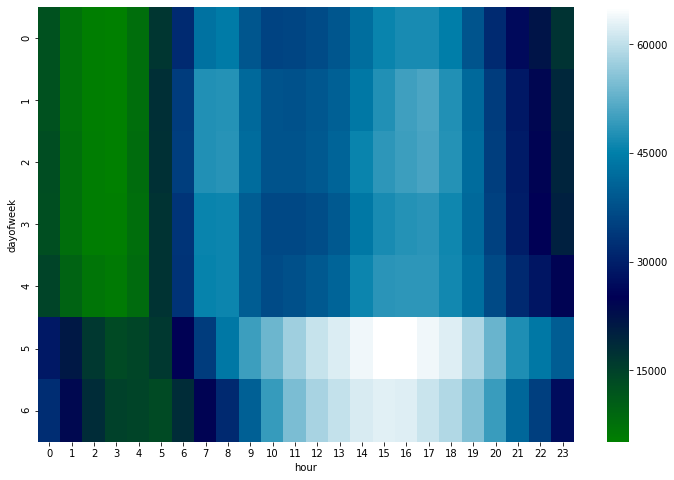

In [68]:
tp= data.pivot_table(index='dayofweek', columns='hour',values='Count')
#tp.fillna(tp.mean(), inplace=True)
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

In [69]:
tp.isnull().sum()

hour
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64

There are no missed values - this heatmap is useful

## dayofweek-month

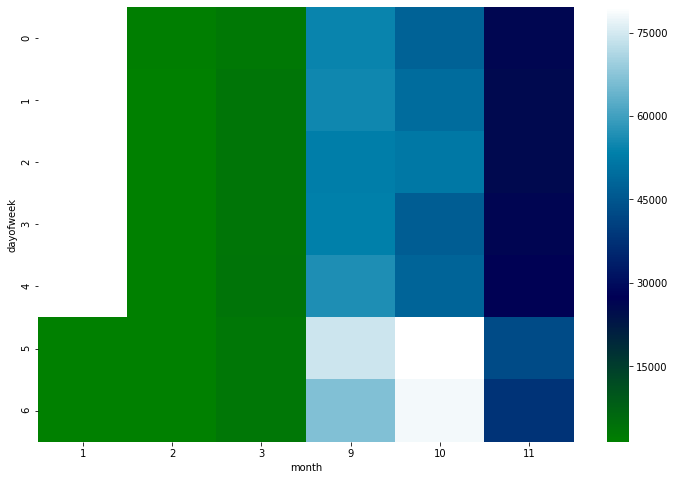

In [70]:
tp= data.pivot_table(index='dayofweek', columns='month',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

There are missed values - this heatmap is not useful

## month-hour

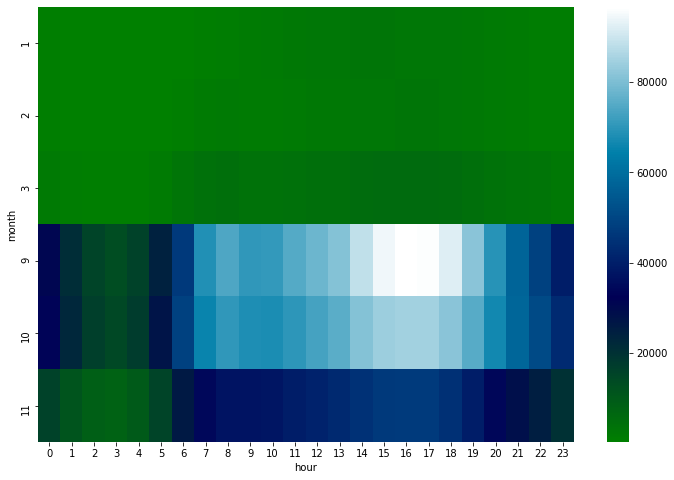

In [71]:
tp= data.pivot_table(index='month', columns='hour',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

This heatmap is not useful too

## day-hour

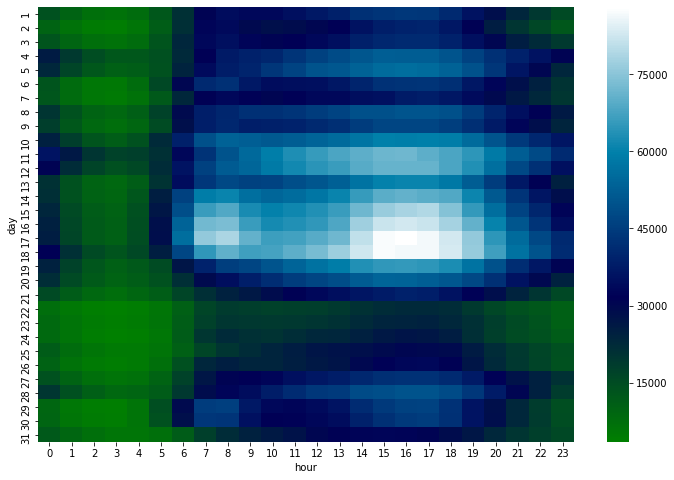

In [72]:
tp= data.pivot_table(index='day', columns='hour',values='Count')  
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

In [64]:
tp.isnull().sum()

hour
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64

This one is useful, and a pair of useful too:

## hour-is_month_start

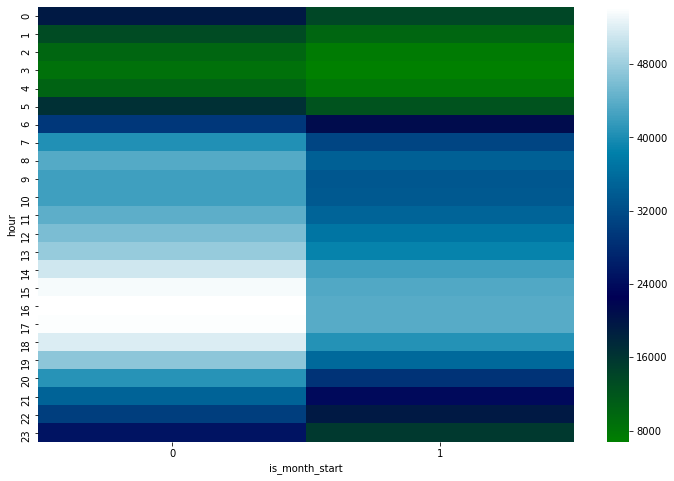

In [73]:
tp= data.pivot_table(index='hour', columns='is_month_start',values='Count')
#tp.fillna(tp.mean(), inplace=True)
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

## hour-is_quarter_start

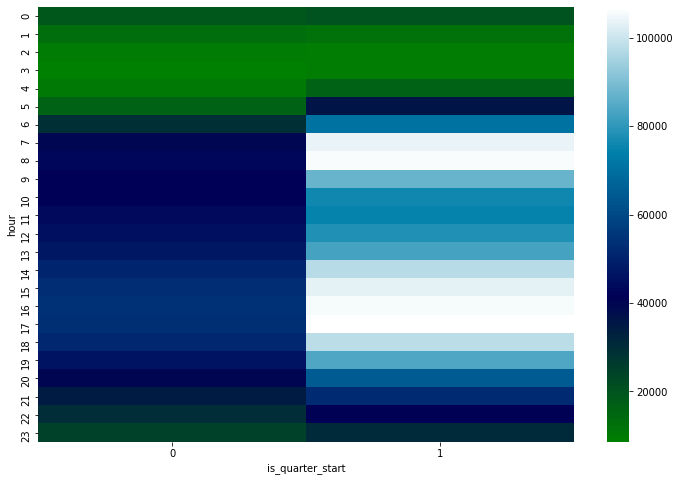

In [74]:
tp= data.pivot_table(index='hour', columns='is_quarter_start',values='Count')
#tp.fillna(tp.mean(), inplace=True)
f, ax = plt.subplots(figsize=(12, 8))
ax=sns.heatmap(tp, annot=False, cmap='ocean')

So, to master features it is possible to use 4 pairs: 
    - dayofweek-hour
    - day-hour
    - hour-is_month_start
    - hour-is_quarter_start
    

The same pairs are mastering for each destination

In [86]:
# движение в северном направлении
df_NB=df2[df2.Direction=='NB'][:'2016-03-27']
df_NB=df_NB.groupby(df_NB.index)[df2.iloc[:,7:].columns].sum()
# движение в южном направлении
df_SB=df2[df2.Direction=='SB'][:'2016-03-27']
df_SB=df_SB.groupby(df_SB.index)[df2.iloc[:,7:].columns].sum()
# движение в западном направлении
df_WB=df2[df2.Direction=='WB'][:'2016-03-27']
df_WB=df_WB.groupby(df_WB.index)[df2.iloc[:,7:].columns].sum()
# движение в восточном направлении
df_EB=df2[df2.Direction=='EB'][:'2016-03-27']
df_EB=df_EB.groupby(df_EB.index)[df2.iloc[:,7:].columns].sum()

In [87]:
def calc_pivot(df_sum):
    date_rng = pd.date_range(start='2014-09-13', end='2016-06-29 23:00:00', freq='H')
    data=pd.DataFrame(index=date_rng)
    data['date_2']=data.index.strftime("%Y-%m-%d")
    criteria=[x in list(df_sum.index.strftime("%Y-%m-%d")) for x in list(data.date_2)]
    data=data[criteria]
    data['hour']=data.index.hour
    cols=df_sum.columns
    series=[]
    for i in range(len(data)):
        x=data.date_2[i]
        y=data.hour[i]
        res=df_sum.loc[x,cols[y]]
        series.append(res)
    data['Count']=series
    data=data.assign(dayofweek=data.index.dayofweek)
    #data=data.assign(month=data.index.month)
    data=data.assign(day=data.index.day)
    #data=data.assign(quarter=data.index.quarter)
    data=data.assign(is_month_start=data.index.is_month_start*1)
    data=data.assign(is_quarter_start=data.index.is_quarter_start*1)
    #data=data.assign(is_year_start=data.index.is_year_start*1)
    #data=data.assign(is_month_end=data.index.is_month_end*1)
    #data=data.assign(is_quarter_end=data.index.is_quarter_end*1)
    #data=data.assign(is_year_end=data.index.is_year_end*1)
    
    tp_dw_h= data.pivot_table(index='dayofweek', columns='hour',values='Count')
    tp_d_h= data.pivot_table(index='day', columns='hour',values='Count')  
    tp_h_ms= data.pivot_table(index='hour', columns='is_month_start',values='Count')
    tp_h_qs= data.pivot_table(index='hour', columns='is_quarter_start',values='Count')
    return tp_dw_h, tp_d_h, tp_h_ms, tp_h_qs

Create dataframes and save them to the disc.

In [89]:
data_list=[df_A, df_EB, df_NB, df_SB, df_WB]
data_names=['df_A', 'df_EB', 'df_NB', 'df_SB', 'df_WB']
for data, name in zip(data_list,data_names):
    res=calc_pivot(data)
    res_list=[res[0], res[1], res[2], res[3]]
    res_names=['tp_dw_h', 'tp_d_h', 'tp_h_ms', 'tp_h_qs']
    for res_df, res_name in zip(res_list, res_names):
        file_name=name+res_name+'.csv'
        res_df.to_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, sep = ',')

In [103]:
num_ts='1180'
name='df_SB'
res_name='tp_d_h'
file_name=name+res_name+'.csv'
# загрузка данных
ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='day')



In [116]:
data_names=['df_A', 'df_EB', 'df_NB', 'df_SB', 'df_WB']
res_names=['tp_dw_h', 'tp_d_h', 'tp_h_ms', 'tp_h_qs']
series_11=data_preprocessing(num_ts, num_features)
df=series_11[0]
for name in data_names:
    # dayofweek - hour
    file_name=name+res_names[0]+'.csv'
    ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='dayofweek')
    df[name+res_names[0]]=[ts.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.hour)]
    # day - hour
    file_name=name+res_names[1]+'.csv'
    ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='day')
    df[name+res_names[1]]=[ts.iloc[x,y] for x,y in zip(df.index.day-1, df.index.hour)]
    # hour - month-start
    file_name=name+res_names[2]+'.csv'
    ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='hour')
    df[name+res_names[2]]=[ts.iloc[x,y] for x,y in zip(df.index.hour, df.index.is_month_start*1)]
    # hour - quartal-start
    file_name=name+res_names[3]+'.csv'
    ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='hour')
    df[name+res_names[3]]=[ts.iloc[x,y] for x,y in zip(df.index.hour, df.index.is_quarter_start*1)]

Combining all actions into the function:

In [123]:
def add_traffic(series_11):
    df=series_11
    data_names=['df_A', 'df_EB', 'df_NB', 'df_SB', 'df_WB']
    res_names=['tp_dw_h', 'tp_d_h', 'tp_h_ms', 'tp_h_qs']
    for name in data_names:
        # dayofweek - hour
        file_name=name+res_names[0]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='dayofweek')
        df[name+res_names[0]]=[ts.iloc[x,y] for x,y in zip(df.index.dayofweek, df.index.hour)]
        # day - hour
        file_name=name+res_names[1]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='day')
        df[name+res_names[1]]=[ts.iloc[x,y] for x,y in zip(df.index.day-1, df.index.hour)]
        # hour - month-start
        file_name=name+res_names[2]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='hour')
        df[name+res_names[2]]=[ts.iloc[x,y] for x,y in zip(df.index.hour, df.index.is_month_start*1)]
        # hour - quartal-start
        file_name=name+res_names[3]+'.csv'
        ts=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/C6W6_step_2_clusters/traffic//'+file_name, index_col='hour')
        df[name+res_names[3]]=[ts.iloc[x,y] for x,y in zip(df.index.hour, df.index.is_quarter_start*1)]
    grouped=df
    return grouped

<a id='section_clust'></a>
# The fatures related with cluster centers, airport region and bus station

Here I try to establish a connection to the cluster centers as well as to the cells containing the airport and the bus station, suggesting that traffic from and in other regions is correlated with incoming passengers. So that’s where they’re going. Clusters are here to unify some dependencies.

I added distances and the number of passengers from the raw data, as the features

- 2069, 2119 - John F. Kennedy International Airport
- 1182 - Port Authority Bus Terminal

Cluster centers:

- ts_cl_0='1334'
- ts_cl_1='1326'
- ts_cl_2='1387'
- ts_cl_3='2068'
- ts_cl_4='1530'

In [ ]:
def add_cluster(series_12):
    reg_list=['2069', '2119', '1182', '1334', '1326', '1387', '2068', '1530']
    
    cofirmed_lst=[x for x in reg_list if x != num_ts]
    for num_ts_add in cofirmed_lst:
        
        ts=quick_preprocessing(num_ts)
        ts_add=quick_preprocessing(num_ts_add)
        series=ts-ts_add
        name=num_ts_add+'_add'
        series_12[name]=series
        
        file_name=num_ts_add+'_df'+'.csv'
        series=pd.read_csv('D:/Asus/Work_DATA/Taxi/C6W6/Time_series_2//'+file_name, index_col=0)
        series=series[series.columns[pd.Series(series.columns).str.startswith('passenger')]].add_suffix(num_ts_add)
        series_12=series_12.join(series)
    groupped=series_12
    return groupped

<a id='section_invest'></a>
# Checking the model improvement

##  Checking, if the model includes new features in 260 selecting

In [146]:
num_ts='1180'
data=data_preprocessing_stage_2_2(num_ts,260)
list(data[0].columns)

['Count',
 '1',
 '10',
 '1129_n',
 '1130_n',
 '1131_n',
 '1179_n',
 '1181_n',
 '1229_n',
 '1230_n',
 '1231_n',
 '13',
 '16',
 '2',
 '20',
 '3',
 '30',
 '31',
 '36',
 '37',
 '38',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '48',
 '49',
 '5',
 '51',
 '55',
 '56',
 '59',
 '60',
 '62',
 '63',
 '64',
 '69',
 '7',
 '70',
 '9',
 'CRD',
 'CSH',
 'DIS',
 'ch_10',
 'ch_11',
 'ch_13',
 'ch_15',
 'ch_17',
 'ch_18',
 'ch_2',
 'ch_22',
 'ch_27',
 'ch_4',
 'ch_42',
 'ch_7',
 'ch_9',
 'cw_1',
 'cw_10',
 'cw_11',
 'cw_13',
 'cw_14',
 'cw_15',
 'cw_16',
 'cw_17',
 'cw_2',
 'cw_21',
 'cw_22',
 'cw_23',
 'cw_27',
 'cw_28',
 'cw_29',
 'cw_31',
 'cw_32',
 'cw_33',
 'cw_35',
 'cw_37',
 'cw_39',
 'cw_40',
 'cw_41',
 'cw_42',
 'cw_46',
 'cw_49',
 'cw_5',
 'cw_6',
 'cw_7',
 'cw_9',
 'cy_10',
 'cy_15',
 'cy_16',
 'cy_17',
 'cy_18',
 'cy_21',
 'cy_23',
 'cy_28',
 'cy_31',
 'cy_39',
 'cy_40',
 'cy_42',
 'cy_46',
 'cy_47',
 'cy_50',
 'cy_7',
 'cy_8',
 'cy_9',
 'd_dw_3',
 'd_h_3',
 'df_Atp_d_h',
 'df_At

In [147]:
## 13 of 20 are included
['df_Atp_d_h',
 'df_Atp_dw_h',
 'df_Atp_h_ms',
 'df_EBtp_d_h',
 'df_EBtp_h_ms',
 'df_NBtp_d_h',
 'df_NBtp_dw_h',
 'df_NBtp_h_ms',
 'df_SBtp_d_h',
 'df_SBtp_dw_h',
 'df_WBtp_d_h',
 'df_WBtp_dw_h',
 'df_WBtp_h_qs']

['df_Atp_d_h',
 'df_Atp_dw_h',
 'df_Atp_h_ms',
 'df_EBtp_d_h',
 'df_EBtp_h_ms',
 'df_NBtp_d_h',
 'df_NBtp_dw_h',
 'df_NBtp_h_ms',
 'df_SBtp_d_h',
 'df_SBtp_dw_h',
 'df_WBtp_d_h',
 'df_WBtp_dw_h',
 'df_WBtp_h_qs']

## Now, try to understand their impotance

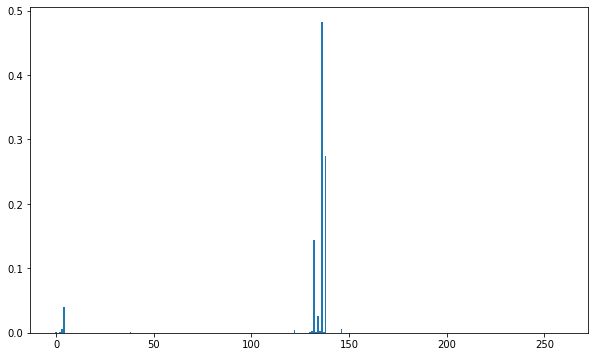

In [157]:
# check feature importance
# split data into X and y
X = data[0].iloc[:,1:]
y = data[0].iloc[:,:1:]
# fit model on training data
model = XGBRegressor()
model.fit(X, y)
# feature importance
#print(model.feature_importances_)
# plot
fig, ax = plt.subplots(figsize=(10,6))
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plt.axis([125,150,0,0.3])
pyplot.show()

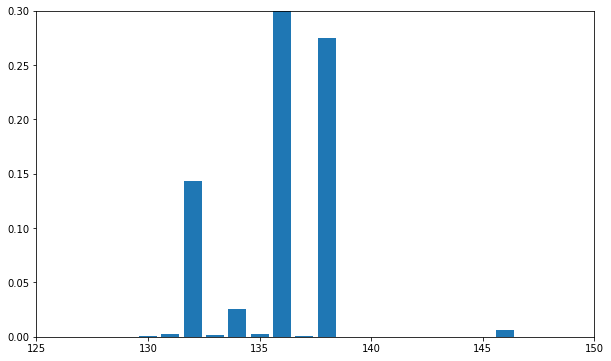

In [158]:
fig, ax = plt.subplots(figsize=(10,6))
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.axis([125,150,0,0.3])
pyplot.show()

In [159]:
list(data[0].columns)[129:147]

['mnth_cos',
 'mnth_sin',
 'passenger_count',
 'passenger_count_12_m',
 'passenger_count_12_s',
 'passenger_count_168_m',
 'passenger_count_168_s',
 'passenger_count_24_m',
 'passenger_count_24_s',
 'passenger_count_720_m',
 'passenger_count_720_s',
 'rol_12m',
 'rol_12s',
 'rol_168s',
 'rol_24m',
 'rol_24s',
 'rol_720m',
 'rol_720s']

Here you can see that they are not included to the most important features. But it’s clear what’s in there: the features related to the quantities in the past.

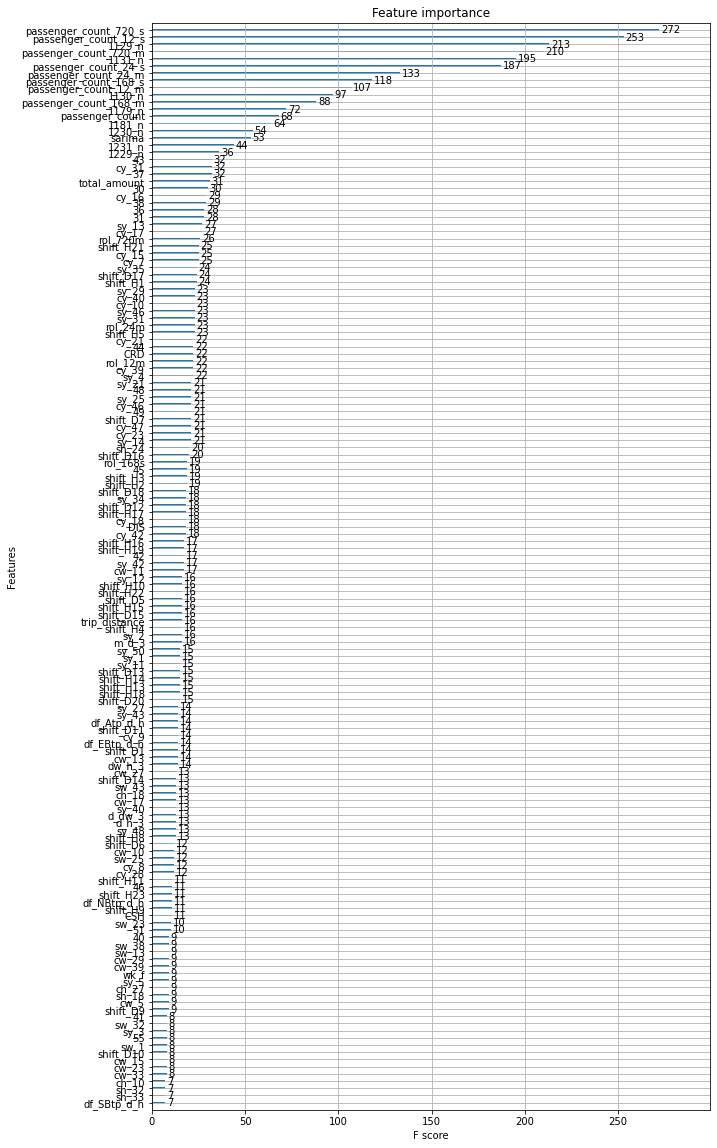

In [169]:
fig, ax = plt.subplots(figsize=(10,20))
plot_importance(model,ax=ax, max_num_features = 150)

pyplot.show()

## Comparison of results with older data

Here I do a number of studies with data: only on old data and on added new data at different values of parameters: number of features, their filtration, etc.

Again, the result is not good: on the old data the model shows the best results.



In [170]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,260)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        
        # split data into train and test sets
        seed = 7
        test_size = 0.33
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
            random_state=seed)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        eval_set = [(X_test, y_test)]
        
        xgb.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="mae",
            eval_set=eval_set, verbose=True)
        
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 20:16:57
Посчитан ряд  1334  за май и июнь 20:26:34
Посчитан ряд  1326  за май и июнь 20:35:12
Посчитан ряд  1387  за май и июнь 20:44:06
Посчитан ряд  2068  за май и июнь 20:53:09
Посчитан ряд  1530  за май и июнь 21:01:55
The end 21:01:55
id
1334_2016-05-31_23_1    83.672249
1334_2016-05-31_23_2    38.424492
1334_2016-05-31_23_3    23.308571
1334_2016-05-31_23_4    18.842199
1334_2016-05-31_23_5    23.763533
Name: y, dtype: float64


In [ ]:
# Результат на старых параметрах
Ошибка за май:  14.395922980664224
Ошибка за июнь:  12.746588964922168

In [171]:
# набор параметров 1
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  14.605648392192887
Ошибка за июнь:  13.729863280055126


In [ ]:
# набор параметров 2
Ошибка за май:  14.611617973407865
Ошибка за июнь:  13.944252269301385

In [ ]:
# набор параметров 3
Ошибка за май:  13.459244782994817
Ошибка за июнь:  12.999694018134711


## Trying to use early interruption to prevent overfitting

Here I am experimenting with the early interruption of model training. 

But again, it didn’t work.

In [183]:
num_ts='1530'
param=[0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01]
num_features=260
grouped=data_preprocessing_stage_2_2(num_ts, num_features)
grouped_=grouped[0].drop('Count', axis=1)
X=grouped_.loc[:'2016.04.30 23:00',:]
Y=np.array(grouped[0].loc[:'2016.04.30 23:00','Count']).reshape(-1)
# split data into train and test sets
seed = 7
test_size = 0.05
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
random_state=seed)

# fit model on all training data
model = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])

eval_set = [(X_test, y_test)]
model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="mae",
eval_set=eval_set, verbose=True)

# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = mean_absolute_error(y_test, predictions)
print("Accuracy: ", accuracy)

[0]	validation_0-mae:12.77613
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:12.39297
[2]	validation_0-mae:12.02139
[3]	validation_0-mae:11.66051
[4]	validation_0-mae:11.31109
[5]	validation_0-mae:10.97171
[6]	validation_0-mae:10.64262
[7]	validation_0-mae:10.32356
[8]	validation_0-mae:10.01369
[9]	validation_0-mae:9.71288
[10]	validation_0-mae:9.42114
[11]	validation_0-mae:9.13795
[12]	validation_0-mae:8.86407
[13]	validation_0-mae:8.59874
[14]	validation_0-mae:8.34115
[15]	validation_0-mae:8.09070
[16]	validation_0-mae:7.84837
[17]	validation_0-mae:7.61234
[18]	validation_0-mae:7.38352
[19]	validation_0-mae:7.16243
[20]	validation_0-mae:6.94783
[21]	validation_0-mae:6.73885
[22]	validation_0-mae:6.53644
[23]	validation_0-mae:6.34065
[24]	validation_0-mae:6.15027
[25]	validation_0-mae:5.96566
[26]	validation_0-mae:5.78688
[27]	validation_0-mae:5.61322
[28]	validation_0-mae:5.44465
[29]	validation_0-mae:5.28137
[30]	validation_0-mae:5.12334
[31]	va

[266]	validation_0-mae:0.14651
[267]	validation_0-mae:0.14661
[268]	validation_0-mae:0.14655
[269]	validation_0-mae:0.14652
[270]	validation_0-mae:0.14657
[271]	validation_0-mae:0.14660
[272]	validation_0-mae:0.14666
[273]	validation_0-mae:0.14662
[274]	validation_0-mae:0.14652
[275]	validation_0-mae:0.14647
[276]	validation_0-mae:0.14660
[277]	validation_0-mae:0.14654
[278]	validation_0-mae:0.14643
[279]	validation_0-mae:0.14645
[280]	validation_0-mae:0.14640
[281]	validation_0-mae:0.14640
[282]	validation_0-mae:0.14635
[283]	validation_0-mae:0.14642
[284]	validation_0-mae:0.14638
[285]	validation_0-mae:0.14644
[286]	validation_0-mae:0.14647
[287]	validation_0-mae:0.14644
[288]	validation_0-mae:0.14645
[289]	validation_0-mae:0.14644
[290]	validation_0-mae:0.14638
[291]	validation_0-mae:0.14635
[292]	validation_0-mae:0.14632
[293]	validation_0-mae:0.14631
[294]	validation_0-mae:0.14637
[295]	validation_0-mae:0.14636
[296]	validation_0-mae:0.14628
[297]	validation_0-mae:0.14626
[298]	va

In [184]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,260)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-04-30 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        
        # split data into train and test sets
        seed = 7
        test_size = 0.05
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
            random_state=seed)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        eval_set = [(X_test, y_test)]
        
        xgb.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="mae",
            eval_set=eval_set, verbose=False)
        
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=['1334', '1326', '1387', '2068', '1530']
sample_param=[[0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 22:27:33
[0]	validation_0-mae:446.95511
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:433.54187
[2]	validation_0-mae:420.47748
[3]	validation_0-mae:407.85571
[4]	validation_0-mae:395.60440
[5]	validation_0-mae:383.70676
[6]	validation_0-mae:372.15347
[7]	validation_0-mae:360.96863
[8]	validation_0-mae:350.11298
[9]	validation_0-mae:339.57407
[10]	validation_0-mae:329.34610
[11]	validation_0-mae:319.43243
[12]	validation_0-mae:309.83646
[13]	validation_0-mae:300.54746
[14]	validation_0-mae:291.51120
[15]	validation_0-mae:282.75803
[16]	validation_0-mae:274.27417
[17]	validation_0-mae:266.01569
[18]	validation_0-mae:258.04013
[19]	validation_0-mae:250.29944
[20]	validation_0-mae:242.78027
[21]	validation_0-mae:235.51579
[22]	validation_0-mae:228.46574
[23]	validation_0-mae:221.59183
[24]	validation_0-mae:214.96144
[25]	validation_0-mae:208.51404
[26]	validation_0-mae:202.27130
[27]	validation_0-mae:196.18416
[28]	validation_0-mae:190.29848
[2

[256]	validation_0-mae:30.38898
[257]	validation_0-mae:30.38713
[258]	validation_0-mae:30.38419
[259]	validation_0-mae:30.38064
[260]	validation_0-mae:30.37948
[261]	validation_0-mae:30.37749
[262]	validation_0-mae:30.37557
[263]	validation_0-mae:30.36844
[264]	validation_0-mae:30.36551
[265]	validation_0-mae:30.36287
[266]	validation_0-mae:30.36154
[267]	validation_0-mae:30.35965
[268]	validation_0-mae:30.35593
[269]	validation_0-mae:30.35614
[270]	validation_0-mae:30.34908
[271]	validation_0-mae:30.34804
[272]	validation_0-mae:30.35068
[273]	validation_0-mae:30.35034
[274]	validation_0-mae:30.34719
[275]	validation_0-mae:30.34603
[276]	validation_0-mae:30.34378
[277]	validation_0-mae:30.34356
[278]	validation_0-mae:30.34561
[279]	validation_0-mae:30.34161
[280]	validation_0-mae:30.34166
[281]	validation_0-mae:30.34628
[282]	validation_0-mae:30.34345
[283]	validation_0-mae:30.33976
[284]	validation_0-mae:30.33395
[285]	validation_0-mae:30.32862
[286]	validation_0-mae:30.32990
[287]	va

[24]	validation_0-mae:213.49170
[25]	validation_0-mae:207.12639
[26]	validation_0-mae:200.91368
[27]	validation_0-mae:194.85844
[28]	validation_0-mae:188.99953
[29]	validation_0-mae:183.35667
[30]	validation_0-mae:177.88336
[31]	validation_0-mae:172.52998
[32]	validation_0-mae:167.39993
[33]	validation_0-mae:162.38652
[34]	validation_0-mae:157.56525
[35]	validation_0-mae:152.89531
[36]	validation_0-mae:148.37904
[37]	validation_0-mae:143.97134
[38]	validation_0-mae:139.72286
[39]	validation_0-mae:135.64441
[40]	validation_0-mae:131.66717
[41]	validation_0-mae:127.83881
[42]	validation_0-mae:124.09450
[43]	validation_0-mae:120.48327
[44]	validation_0-mae:117.01588
[45]	validation_0-mae:113.65472
[46]	validation_0-mae:110.39436
[47]	validation_0-mae:107.23097
[48]	validation_0-mae:104.19079
[49]	validation_0-mae:101.24741
[50]	validation_0-mae:98.39522
[51]	validation_0-mae:95.64140
[52]	validation_0-mae:92.96132
[53]	validation_0-mae:90.39503
[54]	validation_0-mae:87.93603
[55]	validati

[282]	validation_0-mae:32.71199
[283]	validation_0-mae:32.71104
[284]	validation_0-mae:32.71536
[285]	validation_0-mae:32.71146
[286]	validation_0-mae:32.71085
[287]	validation_0-mae:32.70221
[288]	validation_0-mae:32.69484
[289]	validation_0-mae:32.69319
[290]	validation_0-mae:32.69201
[291]	validation_0-mae:32.69271
[292]	validation_0-mae:32.69065
[293]	validation_0-mae:32.68932
[294]	validation_0-mae:32.68483
[295]	validation_0-mae:32.67802
[296]	validation_0-mae:32.67814
[297]	validation_0-mae:32.68002
[298]	validation_0-mae:32.67801
[299]	validation_0-mae:32.66738
[300]	validation_0-mae:32.66496
[301]	validation_0-mae:32.66005
[302]	validation_0-mae:32.65315
[303]	validation_0-mae:32.65130
[304]	validation_0-mae:32.65357
[305]	validation_0-mae:32.64862
[306]	validation_0-mae:32.64145
[307]	validation_0-mae:32.63371
[308]	validation_0-mae:32.63444
[309]	validation_0-mae:32.63207
[310]	validation_0-mae:32.62106
[311]	validation_0-mae:32.61780
[312]	validation_0-mae:32.61561
[313]	va

[539]	validation_0-mae:32.13589
[540]	validation_0-mae:32.13290
[541]	validation_0-mae:32.13179
[542]	validation_0-mae:32.13385
[543]	validation_0-mae:32.13551
[544]	validation_0-mae:32.13686
[545]	validation_0-mae:32.13348
[546]	validation_0-mae:32.13291
[547]	validation_0-mae:32.13405
[548]	validation_0-mae:32.13267
[549]	validation_0-mae:32.12877
[550]	validation_0-mae:32.12534
[551]	validation_0-mae:32.12599
[552]	validation_0-mae:32.12418
[553]	validation_0-mae:32.12450
[554]	validation_0-mae:32.12391
[555]	validation_0-mae:32.11831
[556]	validation_0-mae:32.11453
[557]	validation_0-mae:32.11538
[558]	validation_0-mae:32.11695
[559]	validation_0-mae:32.11358
[560]	validation_0-mae:32.11100
[561]	validation_0-mae:32.10865
[562]	validation_0-mae:32.10549
[563]	validation_0-mae:32.10641
[564]	validation_0-mae:32.10551
[565]	validation_0-mae:32.10164
[566]	validation_0-mae:32.10086
[567]	validation_0-mae:32.09877
[568]	validation_0-mae:32.09981
[569]	validation_0-mae:32.09748
[570]	va

[52]	validation_0-mae:95.65937
[53]	validation_0-mae:93.08884
[54]	validation_0-mae:90.63950
[55]	validation_0-mae:88.29514
[56]	validation_0-mae:86.00611
[57]	validation_0-mae:83.80492
[58]	validation_0-mae:81.70561
[59]	validation_0-mae:79.69227
[60]	validation_0-mae:77.74078
[61]	validation_0-mae:75.83224
[62]	validation_0-mae:74.02374
[63]	validation_0-mae:72.28577
[64]	validation_0-mae:70.61284
[65]	validation_0-mae:69.00558
[66]	validation_0-mae:67.44053
[67]	validation_0-mae:65.94173
[68]	validation_0-mae:64.49557
[69]	validation_0-mae:63.09475
[70]	validation_0-mae:61.78002
[71]	validation_0-mae:60.50883
[72]	validation_0-mae:59.29222
[73]	validation_0-mae:58.11797
[74]	validation_0-mae:57.00539
[75]	validation_0-mae:55.96093
[76]	validation_0-mae:54.95189
[77]	validation_0-mae:54.01140
[78]	validation_0-mae:53.10309
[79]	validation_0-mae:52.21561
[80]	validation_0-mae:51.39946
[81]	validation_0-mae:50.60893
[82]	validation_0-mae:49.85924
[83]	validation_0-mae:49.14683
[84]	val

[310]	validation_0-mae:34.00409
[311]	validation_0-mae:34.00417
[312]	validation_0-mae:33.99388
[313]	validation_0-mae:33.99188
[314]	validation_0-mae:33.98599
[315]	validation_0-mae:33.97866
[316]	validation_0-mae:33.97368
[317]	validation_0-mae:33.97071
[318]	validation_0-mae:33.96159
[319]	validation_0-mae:33.95682
[320]	validation_0-mae:33.95488
[321]	validation_0-mae:33.94785
[322]	validation_0-mae:33.94592
[323]	validation_0-mae:33.94162
[324]	validation_0-mae:33.94210
[325]	validation_0-mae:33.94265
[326]	validation_0-mae:33.93893
[327]	validation_0-mae:33.93914
[328]	validation_0-mae:33.93747
[329]	validation_0-mae:33.93467
[330]	validation_0-mae:33.92885
[331]	validation_0-mae:33.92528
[332]	validation_0-mae:33.92539
[333]	validation_0-mae:33.92276
[334]	validation_0-mae:33.91584
[335]	validation_0-mae:33.90987
[336]	validation_0-mae:33.90042
[337]	validation_0-mae:33.89231
[338]	validation_0-mae:33.87930
[339]	validation_0-mae:33.87621
[340]	validation_0-mae:33.86798
[341]	va

[567]	validation_0-mae:33.36109
[568]	validation_0-mae:33.35492
[569]	validation_0-mae:33.35293
[570]	validation_0-mae:33.34721
[571]	validation_0-mae:33.34129
[572]	validation_0-mae:33.33765
[573]	validation_0-mae:33.33486
[574]	validation_0-mae:33.33539
[575]	validation_0-mae:33.32717
[576]	validation_0-mae:33.32417
[577]	validation_0-mae:33.32105
[578]	validation_0-mae:33.32199
[579]	validation_0-mae:33.31910
[580]	validation_0-mae:33.31755
[581]	validation_0-mae:33.31772
[582]	validation_0-mae:33.31501
[583]	validation_0-mae:33.31647
[584]	validation_0-mae:33.31428
[585]	validation_0-mae:33.31249
[586]	validation_0-mae:33.30355
[587]	validation_0-mae:33.30269
[588]	validation_0-mae:33.29815
[589]	validation_0-mae:33.29762
[590]	validation_0-mae:33.29617
[591]	validation_0-mae:33.29407
[592]	validation_0-mae:33.29046
[593]	validation_0-mae:33.29187
[594]	validation_0-mae:33.28812
[595]	validation_0-mae:33.28288
[596]	validation_0-mae:33.28113
[597]	validation_0-mae:33.28213
[598]	va

[824]	validation_0-mae:33.00839
[825]	validation_0-mae:33.01260
[826]	validation_0-mae:33.01083
[827]	validation_0-mae:33.00951
[828]	validation_0-mae:33.00864
[829]	validation_0-mae:33.00773
[830]	validation_0-mae:33.00947
[831]	validation_0-mae:33.00758
[832]	validation_0-mae:33.00732
[833]	validation_0-mae:33.00765
[834]	validation_0-mae:33.00523
[835]	validation_0-mae:33.00374
[836]	validation_0-mae:33.00319
[837]	validation_0-mae:32.99994
[838]	validation_0-mae:33.00118
[839]	validation_0-mae:33.00291
[840]	validation_0-mae:33.00191
[841]	validation_0-mae:33.00024
[842]	validation_0-mae:32.99894
[843]	validation_0-mae:32.99813
[844]	validation_0-mae:32.99682
[845]	validation_0-mae:32.99486
[846]	validation_0-mae:32.99250
[847]	validation_0-mae:32.99168
[848]	validation_0-mae:32.98898
[849]	validation_0-mae:32.98921
[850]	validation_0-mae:32.98826
[851]	validation_0-mae:32.98796
[852]	validation_0-mae:32.98780
[853]	validation_0-mae:32.98691
[854]	validation_0-mae:32.98582
[855]	va

[143]	validation_0-mae:36.37193
[144]	validation_0-mae:36.33483
[145]	validation_0-mae:36.30683
[146]	validation_0-mae:36.25414
[147]	validation_0-mae:36.21317
[148]	validation_0-mae:36.19117
[149]	validation_0-mae:36.15891
[150]	validation_0-mae:36.12786
[151]	validation_0-mae:36.09971
[152]	validation_0-mae:36.08361
[153]	validation_0-mae:36.06656
[154]	validation_0-mae:36.04648
[155]	validation_0-mae:36.02713
[156]	validation_0-mae:35.99447
[157]	validation_0-mae:35.98013
[158]	validation_0-mae:35.96252
[159]	validation_0-mae:35.94003
[160]	validation_0-mae:35.92939
[161]	validation_0-mae:35.90274
[162]	validation_0-mae:35.88042
[163]	validation_0-mae:35.85419
[164]	validation_0-mae:35.83085
[165]	validation_0-mae:35.81347
[166]	validation_0-mae:35.79637
[167]	validation_0-mae:35.78057
[168]	validation_0-mae:35.76009
[169]	validation_0-mae:35.75001
[170]	validation_0-mae:35.73154
[171]	validation_0-mae:35.72290
[172]	validation_0-mae:35.69649
[173]	validation_0-mae:35.68686
[174]	va

[400]	validation_0-mae:34.29196
[401]	validation_0-mae:34.28566
[402]	validation_0-mae:34.28170
[403]	validation_0-mae:34.27677
[404]	validation_0-mae:34.27722
[405]	validation_0-mae:34.27650
[406]	validation_0-mae:34.27460
[407]	validation_0-mae:34.27586
[408]	validation_0-mae:34.27842
[409]	validation_0-mae:34.27245
[410]	validation_0-mae:34.26995
[411]	validation_0-mae:34.26176
[412]	validation_0-mae:34.25720
[413]	validation_0-mae:34.25095
[414]	validation_0-mae:34.24686
[415]	validation_0-mae:34.24123
[416]	validation_0-mae:34.24116
[417]	validation_0-mae:34.24235
[418]	validation_0-mae:34.24037
[419]	validation_0-mae:34.23529
[420]	validation_0-mae:34.23113
[421]	validation_0-mae:34.23106
[422]	validation_0-mae:34.23064
[423]	validation_0-mae:34.22311
[424]	validation_0-mae:34.22445
[425]	validation_0-mae:34.22311
[426]	validation_0-mae:34.22790
[427]	validation_0-mae:34.22487
[428]	validation_0-mae:34.22322
[429]	validation_0-mae:34.22313
[430]	validation_0-mae:34.22184
[431]	va

[657]	validation_0-mae:33.73095
[658]	validation_0-mae:33.73000
[659]	validation_0-mae:33.73010
[660]	validation_0-mae:33.72997
[661]	validation_0-mae:33.72609
[662]	validation_0-mae:33.72247
[663]	validation_0-mae:33.72330
[664]	validation_0-mae:33.72104
[665]	validation_0-mae:33.72144
[666]	validation_0-mae:33.72112
[667]	validation_0-mae:33.72451
[668]	validation_0-mae:33.72644
[669]	validation_0-mae:33.72406
[670]	validation_0-mae:33.72065
[671]	validation_0-mae:33.72104
[672]	validation_0-mae:33.71863
[673]	validation_0-mae:33.71677
[674]	validation_0-mae:33.71817
[675]	validation_0-mae:33.71748
[676]	validation_0-mae:33.71836
[677]	validation_0-mae:33.71801
[678]	validation_0-mae:33.71271
[679]	validation_0-mae:33.71249
[680]	validation_0-mae:33.70842
[681]	validation_0-mae:33.70653
[682]	validation_0-mae:33.70937
[683]	validation_0-mae:33.70867
[684]	validation_0-mae:33.70475
[685]	validation_0-mae:33.70293
[686]	validation_0-mae:33.70155
[687]	validation_0-mae:33.70373
[688]	va

[914]	validation_0-mae:33.41308
[915]	validation_0-mae:33.41227
[916]	validation_0-mae:33.41146
[917]	validation_0-mae:33.40995
[918]	validation_0-mae:33.40838
[919]	validation_0-mae:33.40666
[920]	validation_0-mae:33.40560
[921]	validation_0-mae:33.40493
[922]	validation_0-mae:33.40492
[923]	validation_0-mae:33.40228
[924]	validation_0-mae:33.40342
[925]	validation_0-mae:33.40289
[926]	validation_0-mae:33.40190
[927]	validation_0-mae:33.40132
[928]	validation_0-mae:33.39709
[929]	validation_0-mae:33.39563
[930]	validation_0-mae:33.39547
[931]	validation_0-mae:33.39300
[932]	validation_0-mae:33.39381
[933]	validation_0-mae:33.38976
[934]	validation_0-mae:33.38982
[935]	validation_0-mae:33.38942
[936]	validation_0-mae:33.39067
[937]	validation_0-mae:33.39127
[938]	validation_0-mae:33.39215
[939]	validation_0-mae:33.38981
[940]	validation_0-mae:33.38899
[941]	validation_0-mae:33.38519
[942]	validation_0-mae:33.38386
[943]	validation_0-mae:33.37969
[944]	validation_0-mae:33.37891
[945]	va

[1165]	validation_0-mae:33.17018
[1166]	validation_0-mae:33.16951
[1167]	validation_0-mae:33.16949
[1168]	validation_0-mae:33.16929
[1169]	validation_0-mae:33.16585
[1170]	validation_0-mae:33.16557
[1171]	validation_0-mae:33.16413
[1172]	validation_0-mae:33.16288
[1173]	validation_0-mae:33.16172
[1174]	validation_0-mae:33.16324
[1175]	validation_0-mae:33.16293
[1176]	validation_0-mae:33.16194
[1177]	validation_0-mae:33.16017
[1178]	validation_0-mae:33.15906
[1179]	validation_0-mae:33.15828
[1180]	validation_0-mae:33.15814
[1181]	validation_0-mae:33.15848
[1182]	validation_0-mae:33.15808
[1183]	validation_0-mae:33.15808
[1184]	validation_0-mae:33.15726
[1185]	validation_0-mae:33.15747
[1186]	validation_0-mae:33.15780
[1187]	validation_0-mae:33.15644
[1188]	validation_0-mae:33.15646
[1189]	validation_0-mae:33.15624
[1190]	validation_0-mae:33.15620
[1191]	validation_0-mae:33.15550
[1192]	validation_0-mae:33.15606
[1193]	validation_0-mae:33.15474
[1194]	validation_0-mae:33.15290
[1195]	val

[220]	validation_0-mae:34.43361
[221]	validation_0-mae:34.42697
[222]	validation_0-mae:34.41720
[223]	validation_0-mae:34.40708
[224]	validation_0-mae:34.39986
[225]	validation_0-mae:34.39355
[226]	validation_0-mae:34.38243
[227]	validation_0-mae:34.37010
[228]	validation_0-mae:34.36353
[229]	validation_0-mae:34.36297
[230]	validation_0-mae:34.35919
[231]	validation_0-mae:34.35541
[232]	validation_0-mae:34.34710
[233]	validation_0-mae:34.33635
[234]	validation_0-mae:34.33508
[235]	validation_0-mae:34.32774
[236]	validation_0-mae:34.31912
[237]	validation_0-mae:34.31365
[238]	validation_0-mae:34.31628
[239]	validation_0-mae:34.29814
[240]	validation_0-mae:34.29034
[241]	validation_0-mae:34.28649
[242]	validation_0-mae:34.26915
[243]	validation_0-mae:34.25666
[244]	validation_0-mae:34.24677
[245]	validation_0-mae:34.24229
[246]	validation_0-mae:34.23651
[247]	validation_0-mae:34.22866
[248]	validation_0-mae:34.22588
[249]	validation_0-mae:34.21836
[250]	validation_0-mae:34.20822
[251]	va

[477]	validation_0-mae:33.32993
[478]	validation_0-mae:33.32841
[479]	validation_0-mae:33.32528
[480]	validation_0-mae:33.32035
[481]	validation_0-mae:33.32136
[482]	validation_0-mae:33.31555
[483]	validation_0-mae:33.31359
[484]	validation_0-mae:33.31210
[485]	validation_0-mae:33.30749
[486]	validation_0-mae:33.30533
[487]	validation_0-mae:33.30500
[488]	validation_0-mae:33.29746
[489]	validation_0-mae:33.29326
[490]	validation_0-mae:33.28853
[491]	validation_0-mae:33.28535
[492]	validation_0-mae:33.27943
[493]	validation_0-mae:33.28070
[494]	validation_0-mae:33.28019
[495]	validation_0-mae:33.27597
[496]	validation_0-mae:33.27610
[497]	validation_0-mae:33.27036
[498]	validation_0-mae:33.26658
[499]	validation_0-mae:33.26275
[500]	validation_0-mae:33.26021
[501]	validation_0-mae:33.26078
[502]	validation_0-mae:33.25829
[503]	validation_0-mae:33.25687
[504]	validation_0-mae:33.25249
[505]	validation_0-mae:33.25202
[506]	validation_0-mae:33.24806
[507]	validation_0-mae:33.24607
[508]	va

[734]	validation_0-mae:32.81887
[735]	validation_0-mae:32.81419
[736]	validation_0-mae:32.81292
[737]	validation_0-mae:32.81276
[738]	validation_0-mae:32.81143
[739]	validation_0-mae:32.80997
[740]	validation_0-mae:32.80942
[741]	validation_0-mae:32.80594
[742]	validation_0-mae:32.80419
[743]	validation_0-mae:32.80212
[744]	validation_0-mae:32.80268
[745]	validation_0-mae:32.80037
[746]	validation_0-mae:32.79868
[747]	validation_0-mae:32.79485
[748]	validation_0-mae:32.79394
[749]	validation_0-mae:32.79239
[750]	validation_0-mae:32.78957
[751]	validation_0-mae:32.78742
[752]	validation_0-mae:32.78796
[753]	validation_0-mae:32.78499
[754]	validation_0-mae:32.78589
[755]	validation_0-mae:32.78392
[756]	validation_0-mae:32.78492
[757]	validation_0-mae:32.78687
[758]	validation_0-mae:32.78693
[759]	validation_0-mae:32.78053
[760]	validation_0-mae:32.77872
[761]	validation_0-mae:32.77590
[762]	validation_0-mae:32.77529
[763]	validation_0-mae:32.77404
[764]	validation_0-mae:32.77402
[765]	va

[991]	validation_0-mae:32.54658
[992]	validation_0-mae:32.54366
[993]	validation_0-mae:32.54451
[994]	validation_0-mae:32.54072
[995]	validation_0-mae:32.54179
[996]	validation_0-mae:32.53909
[997]	validation_0-mae:32.53894
[998]	validation_0-mae:32.53670
[999]	validation_0-mae:32.53505
[1000]	validation_0-mae:32.53423
[1001]	validation_0-mae:32.53402
[1002]	validation_0-mae:32.53313
[1003]	validation_0-mae:32.53321
[1004]	validation_0-mae:32.53196
[1005]	validation_0-mae:32.53125
[1006]	validation_0-mae:32.53255
[1007]	validation_0-mae:32.53256
[1008]	validation_0-mae:32.53369
[1009]	validation_0-mae:32.53348
[1010]	validation_0-mae:32.53344
[1011]	validation_0-mae:32.53347
[1012]	validation_0-mae:32.53304
[1013]	validation_0-mae:32.53220
[1014]	validation_0-mae:32.53073
[1015]	validation_0-mae:32.52909
[1016]	validation_0-mae:32.52734
[1017]	validation_0-mae:32.52775
[1018]	validation_0-mae:32.52695
[1019]	validation_0-mae:32.52685
[1020]	validation_0-mae:32.52940
[1021]	validation_0

[124]	validation_0-mae:37.85111
[125]	validation_0-mae:37.76107
[126]	validation_0-mae:37.68319
[127]	validation_0-mae:37.58917
[128]	validation_0-mae:37.51013
[129]	validation_0-mae:37.43600
[130]	validation_0-mae:37.35119
[131]	validation_0-mae:37.28373
[132]	validation_0-mae:37.22890
[133]	validation_0-mae:37.16838
[134]	validation_0-mae:37.12270
[135]	validation_0-mae:37.07257
[136]	validation_0-mae:37.01135
[137]	validation_0-mae:36.95814
[138]	validation_0-mae:36.90634
[139]	validation_0-mae:36.85557
[140]	validation_0-mae:36.80197
[141]	validation_0-mae:36.76539
[142]	validation_0-mae:36.71312
[143]	validation_0-mae:36.68457
[144]	validation_0-mae:36.64036
[145]	validation_0-mae:36.59467
[146]	validation_0-mae:36.55160
[147]	validation_0-mae:36.50417
[148]	validation_0-mae:36.45552
[149]	validation_0-mae:36.41464
[150]	validation_0-mae:36.38977
[151]	validation_0-mae:36.34848
[152]	validation_0-mae:36.31894
[153]	validation_0-mae:36.29073
[154]	validation_0-mae:36.25582
[155]	va

[381]	validation_0-mae:34.44509
[382]	validation_0-mae:34.44748
[383]	validation_0-mae:34.44868
[384]	validation_0-mae:34.44454
[385]	validation_0-mae:34.44048
[386]	validation_0-mae:34.43844
[387]	validation_0-mae:34.42942
[388]	validation_0-mae:34.41934
[389]	validation_0-mae:34.41413
[390]	validation_0-mae:34.40899
[391]	validation_0-mae:34.40799
[392]	validation_0-mae:34.40487
[393]	validation_0-mae:34.39762
[394]	validation_0-mae:34.39284
[395]	validation_0-mae:34.39246
[396]	validation_0-mae:34.39390
[397]	validation_0-mae:34.39108
[398]	validation_0-mae:34.38867
[399]	validation_0-mae:34.38898
[400]	validation_0-mae:34.38349
[401]	validation_0-mae:34.38186
[402]	validation_0-mae:34.37396
[403]	validation_0-mae:34.36482
[404]	validation_0-mae:34.35899
[405]	validation_0-mae:34.35418
[406]	validation_0-mae:34.34935
[407]	validation_0-mae:34.34443
[408]	validation_0-mae:34.34080
[409]	validation_0-mae:34.33720
[410]	validation_0-mae:34.33305
[411]	validation_0-mae:34.33417
[412]	va

[638]	validation_0-mae:33.72319
[639]	validation_0-mae:33.72082
[640]	validation_0-mae:33.72012
[641]	validation_0-mae:33.72004
[642]	validation_0-mae:33.72206
[643]	validation_0-mae:33.72044
[644]	validation_0-mae:33.71577
[645]	validation_0-mae:33.70734
[646]	validation_0-mae:33.70210
[647]	validation_0-mae:33.70174
[648]	validation_0-mae:33.70070
[649]	validation_0-mae:33.69721
[650]	validation_0-mae:33.68942
[651]	validation_0-mae:33.68985
[652]	validation_0-mae:33.68742
[653]	validation_0-mae:33.68179
[654]	validation_0-mae:33.67925
[655]	validation_0-mae:33.67836
[656]	validation_0-mae:33.67548
[657]	validation_0-mae:33.67340
[658]	validation_0-mae:33.66225
[659]	validation_0-mae:33.66282
[660]	validation_0-mae:33.66261
[661]	validation_0-mae:33.66242
[662]	validation_0-mae:33.65641
[663]	validation_0-mae:33.65223
[664]	validation_0-mae:33.64751
[665]	validation_0-mae:33.64464
[666]	validation_0-mae:33.64445
[667]	validation_0-mae:33.64105
[668]	validation_0-mae:33.63954
[669]	va

[895]	validation_0-mae:33.31261
[896]	validation_0-mae:33.31319
[897]	validation_0-mae:33.31304
[898]	validation_0-mae:33.31206
[899]	validation_0-mae:33.31266
[900]	validation_0-mae:33.30835
[901]	validation_0-mae:33.30872
[902]	validation_0-mae:33.30821
[903]	validation_0-mae:33.30729
[904]	validation_0-mae:33.30248
[905]	validation_0-mae:33.30073
[906]	validation_0-mae:33.29770
[907]	validation_0-mae:33.29784
[908]	validation_0-mae:33.29751
[909]	validation_0-mae:33.29600
[910]	validation_0-mae:33.29600
[911]	validation_0-mae:33.29558
[912]	validation_0-mae:33.29573
[913]	validation_0-mae:33.29777
[914]	validation_0-mae:33.29770
[915]	validation_0-mae:33.29654
[916]	validation_0-mae:33.29783
[917]	validation_0-mae:33.29339
[918]	validation_0-mae:33.29024
[919]	validation_0-mae:33.28727
[920]	validation_0-mae:33.28728
[921]	validation_0-mae:33.28785
[922]	validation_0-mae:33.28773
[923]	validation_0-mae:33.28598
[924]	validation_0-mae:33.28641
[925]	validation_0-mae:33.28323
[926]	va

[176]	validation_0-mae:5.47169
[177]	validation_0-mae:5.47087
[178]	validation_0-mae:5.47137
[179]	validation_0-mae:5.47106
[180]	validation_0-mae:5.47060
[181]	validation_0-mae:5.47014
[182]	validation_0-mae:5.47005
[183]	validation_0-mae:5.46924
[184]	validation_0-mae:5.46932
[185]	validation_0-mae:5.46892
[186]	validation_0-mae:5.46790
[187]	validation_0-mae:5.46760
[188]	validation_0-mae:5.46857
[189]	validation_0-mae:5.46862
[190]	validation_0-mae:5.46799
[191]	validation_0-mae:5.46743
[192]	validation_0-mae:5.46678
[193]	validation_0-mae:5.46662
[194]	validation_0-mae:5.46632
[195]	validation_0-mae:5.46636
[196]	validation_0-mae:5.46623
[197]	validation_0-mae:5.46473
[198]	validation_0-mae:5.46430
[199]	validation_0-mae:5.46394
[200]	validation_0-mae:5.46418
[201]	validation_0-mae:5.46354
[202]	validation_0-mae:5.46248
[203]	validation_0-mae:5.46230
[204]	validation_0-mae:5.46265
[205]	validation_0-mae:5.46239
[206]	validation_0-mae:5.46262
[207]	validation_0-mae:5.46264
[208]	va

[225]	validation_0-mae:5.78877
[226]	validation_0-mae:5.78856
[227]	validation_0-mae:5.78744
[228]	validation_0-mae:5.78695
[229]	validation_0-mae:5.78719
[230]	validation_0-mae:5.78730
[231]	validation_0-mae:5.78735
[232]	validation_0-mae:5.78648
[233]	validation_0-mae:5.78615
[234]	validation_0-mae:5.78619
[235]	validation_0-mae:5.78608
[236]	validation_0-mae:5.78447
[237]	validation_0-mae:5.78383
[238]	validation_0-mae:5.78311
[239]	validation_0-mae:5.78276
[240]	validation_0-mae:5.78158
[241]	validation_0-mae:5.78003
[242]	validation_0-mae:5.77886
[243]	validation_0-mae:5.77739
[244]	validation_0-mae:5.77710
[245]	validation_0-mae:5.77753
[246]	validation_0-mae:5.77785
[247]	validation_0-mae:5.77708
[248]	validation_0-mae:5.77556
[249]	validation_0-mae:5.77512
[250]	validation_0-mae:5.77512
[251]	validation_0-mae:5.77452
[252]	validation_0-mae:5.77421
[253]	validation_0-mae:5.77346
[254]	validation_0-mae:5.77236
[255]	validation_0-mae:5.77124
[256]	validation_0-mae:5.77066
[257]	va

[31]	validation_0-mae:12.04122
[32]	validation_0-mae:11.75560
[33]	validation_0-mae:11.48393
[34]	validation_0-mae:11.21637
[35]	validation_0-mae:10.96639
[36]	validation_0-mae:10.72246
[37]	validation_0-mae:10.48943
[38]	validation_0-mae:10.26420
[39]	validation_0-mae:10.05007
[40]	validation_0-mae:9.84866
[41]	validation_0-mae:9.65179
[42]	validation_0-mae:9.47304
[43]	validation_0-mae:9.29660
[44]	validation_0-mae:9.12911
[45]	validation_0-mae:8.96920
[46]	validation_0-mae:8.81586
[47]	validation_0-mae:8.67395
[48]	validation_0-mae:8.53725
[49]	validation_0-mae:8.40497
[50]	validation_0-mae:8.27758
[51]	validation_0-mae:8.15581
[52]	validation_0-mae:8.04082
[53]	validation_0-mae:7.93338
[54]	validation_0-mae:7.83420
[55]	validation_0-mae:7.73699
[56]	validation_0-mae:7.64818
[57]	validation_0-mae:7.55828
[58]	validation_0-mae:7.47356
[59]	validation_0-mae:7.39398
[60]	validation_0-mae:7.31480
[61]	validation_0-mae:7.24010
[62]	validation_0-mae:7.16811
[63]	validation_0-mae:7.10088
[

[298]	validation_0-mae:5.84228
[299]	validation_0-mae:5.84180
[300]	validation_0-mae:5.84083
[301]	validation_0-mae:5.83994
[302]	validation_0-mae:5.83983
[303]	validation_0-mae:5.83907
[304]	validation_0-mae:5.83836
[305]	validation_0-mae:5.83679
[306]	validation_0-mae:5.83633
[307]	validation_0-mae:5.83571
[308]	validation_0-mae:5.83442
[309]	validation_0-mae:5.83317
[310]	validation_0-mae:5.83255
[311]	validation_0-mae:5.83228
[312]	validation_0-mae:5.83149
[313]	validation_0-mae:5.83103
[314]	validation_0-mae:5.83120
[315]	validation_0-mae:5.83013
[316]	validation_0-mae:5.83012
[317]	validation_0-mae:5.83039
[318]	validation_0-mae:5.83051
[319]	validation_0-mae:5.83025
[320]	validation_0-mae:5.82899
[321]	validation_0-mae:5.82881
[322]	validation_0-mae:5.82861
[323]	validation_0-mae:5.82890
[324]	validation_0-mae:5.82813
[325]	validation_0-mae:5.82741
[326]	validation_0-mae:5.82716
[327]	validation_0-mae:5.82698
[328]	validation_0-mae:5.82657
[329]	validation_0-mae:5.82549
[330]	va

[563]	validation_0-mae:5.75960
[564]	validation_0-mae:5.75967
[565]	validation_0-mae:5.75898
[566]	validation_0-mae:5.75897
[567]	validation_0-mae:5.75834
[568]	validation_0-mae:5.75799
[569]	validation_0-mae:5.75769
[570]	validation_0-mae:5.75777
[571]	validation_0-mae:5.75734
[572]	validation_0-mae:5.75694
[573]	validation_0-mae:5.75671
[574]	validation_0-mae:5.75622
[575]	validation_0-mae:5.75631
[576]	validation_0-mae:5.75544
[577]	validation_0-mae:5.75518
[578]	validation_0-mae:5.75489
[579]	validation_0-mae:5.75459
[580]	validation_0-mae:5.75475
[581]	validation_0-mae:5.75446
[582]	validation_0-mae:5.75443
[583]	validation_0-mae:5.75460
[584]	validation_0-mae:5.75449
[585]	validation_0-mae:5.75432
[586]	validation_0-mae:5.75353
[587]	validation_0-mae:5.75328
[588]	validation_0-mae:5.75308
[589]	validation_0-mae:5.75327
[590]	validation_0-mae:5.75345
[591]	validation_0-mae:5.75311
[592]	validation_0-mae:5.75362
[593]	validation_0-mae:5.75319
[594]	validation_0-mae:5.75234
[595]	va

[150]	validation_0-mae:5.91446
[151]	validation_0-mae:5.91214
[152]	validation_0-mae:5.91193
[153]	validation_0-mae:5.91054
[154]	validation_0-mae:5.90766
[155]	validation_0-mae:5.90591
[156]	validation_0-mae:5.90548
[157]	validation_0-mae:5.90512
[158]	validation_0-mae:5.90406
[159]	validation_0-mae:5.90385
[160]	validation_0-mae:5.90505
[161]	validation_0-mae:5.90350
[162]	validation_0-mae:5.90208
[163]	validation_0-mae:5.90244
[164]	validation_0-mae:5.90165
[165]	validation_0-mae:5.89997
[166]	validation_0-mae:5.89974
[167]	validation_0-mae:5.89924
[168]	validation_0-mae:5.89927
[169]	validation_0-mae:5.89740
[170]	validation_0-mae:5.89493
[171]	validation_0-mae:5.89548
[172]	validation_0-mae:5.89354
[173]	validation_0-mae:5.89378
[174]	validation_0-mae:5.89421
[175]	validation_0-mae:5.89365
[176]	validation_0-mae:5.89211
[177]	validation_0-mae:5.89049
[178]	validation_0-mae:5.88998
[179]	validation_0-mae:5.88971
[180]	validation_0-mae:5.88882
[181]	validation_0-mae:5.88739
[182]	va

[415]	validation_0-mae:5.77376
[416]	validation_0-mae:5.77381
[417]	validation_0-mae:5.77402
[418]	validation_0-mae:5.77454
[419]	validation_0-mae:5.77451
[420]	validation_0-mae:5.77384
[421]	validation_0-mae:5.77328
[422]	validation_0-mae:5.77375
[423]	validation_0-mae:5.77353
[424]	validation_0-mae:5.77344
[425]	validation_0-mae:5.77295
[426]	validation_0-mae:5.77310
[427]	validation_0-mae:5.77210
[428]	validation_0-mae:5.77282
[429]	validation_0-mae:5.77236
[430]	validation_0-mae:5.77255
[431]	validation_0-mae:5.77276
[432]	validation_0-mae:5.77225
[433]	validation_0-mae:5.77247
[434]	validation_0-mae:5.77269
[435]	validation_0-mae:5.77272
[436]	validation_0-mae:5.77227
[437]	validation_0-mae:5.77243
Stopping. Best iteration:
[427]	validation_0-mae:5.77210

[0]	validation_0-mae:29.22116
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:28.35212
[2]	validation_0-mae:27.51136
[3]	validation_0-mae:26.70273
[4]	validation_0-mae:25.91532
[5]	validation_

[240]	validation_0-mae:5.72696
[241]	validation_0-mae:5.72823
[242]	validation_0-mae:5.72797
[243]	validation_0-mae:5.72715
[244]	validation_0-mae:5.72653
[245]	validation_0-mae:5.72607
[246]	validation_0-mae:5.72614
[247]	validation_0-mae:5.72508
[248]	validation_0-mae:5.72390
[249]	validation_0-mae:5.72396
[250]	validation_0-mae:5.72360
[251]	validation_0-mae:5.72204
[252]	validation_0-mae:5.72029
[253]	validation_0-mae:5.72069
[254]	validation_0-mae:5.71977
[255]	validation_0-mae:5.71875
[256]	validation_0-mae:5.71641
[257]	validation_0-mae:5.71501
[258]	validation_0-mae:5.71351
[259]	validation_0-mae:5.71186
[260]	validation_0-mae:5.71160
[261]	validation_0-mae:5.71022
[262]	validation_0-mae:5.70881
[263]	validation_0-mae:5.70864
[264]	validation_0-mae:5.70720
[265]	validation_0-mae:5.70611
[266]	validation_0-mae:5.70623
[267]	validation_0-mae:5.70600
[268]	validation_0-mae:5.70610
[269]	validation_0-mae:5.70540
[270]	validation_0-mae:5.70597
[271]	validation_0-mae:5.70505
[272]	va

[505]	validation_0-mae:5.63042
Stopping. Best iteration:
[495]	validation_0-mae:5.62931

[0]	validation_0-mae:29.30391
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:28.43479
[2]	validation_0-mae:27.57860
[3]	validation_0-mae:26.75465
[4]	validation_0-mae:25.95933
[5]	validation_0-mae:25.19414
[6]	validation_0-mae:24.44998
[7]	validation_0-mae:23.72762
[8]	validation_0-mae:23.03317
[9]	validation_0-mae:22.34919
[10]	validation_0-mae:21.69150
[11]	validation_0-mae:21.06116
[12]	validation_0-mae:20.44492
[13]	validation_0-mae:19.85673
[14]	validation_0-mae:19.28814
[15]	validation_0-mae:18.74026
[16]	validation_0-mae:18.20296
[17]	validation_0-mae:17.67709
[18]	validation_0-mae:17.17588
[19]	validation_0-mae:16.69352
[20]	validation_0-mae:16.22898
[21]	validation_0-mae:15.77531
[22]	validation_0-mae:15.35208
[23]	validation_0-mae:14.93977
[24]	validation_0-mae:14.53967
[25]	validation_0-mae:14.15246
[26]	validation_0-mae:13.78168
[27]	validation_0-ma

[262]	validation_0-mae:5.93389
[263]	validation_0-mae:5.93337
[264]	validation_0-mae:5.93337
[265]	validation_0-mae:5.93267
[266]	validation_0-mae:5.93179
[267]	validation_0-mae:5.93114
[268]	validation_0-mae:5.93071
[269]	validation_0-mae:5.92986
[270]	validation_0-mae:5.92979
[271]	validation_0-mae:5.93006
[272]	validation_0-mae:5.93002
[273]	validation_0-mae:5.92943
[274]	validation_0-mae:5.92921
[275]	validation_0-mae:5.92810
[276]	validation_0-mae:5.92768
[277]	validation_0-mae:5.92764
[278]	validation_0-mae:5.92670
[279]	validation_0-mae:5.92640
[280]	validation_0-mae:5.92581
[281]	validation_0-mae:5.92514
[282]	validation_0-mae:5.92406
[283]	validation_0-mae:5.92409
[284]	validation_0-mae:5.92360
[285]	validation_0-mae:5.92247
[286]	validation_0-mae:5.92045
[287]	validation_0-mae:5.92006
[288]	validation_0-mae:5.91932
[289]	validation_0-mae:5.91965
[290]	validation_0-mae:5.91892
[291]	validation_0-mae:5.91876
[292]	validation_0-mae:5.91844
[293]	validation_0-mae:5.91878
[294]	va

[116]	validation_0-mae:5.23218
[117]	validation_0-mae:5.22927
[118]	validation_0-mae:5.22480
[119]	validation_0-mae:5.22212
[120]	validation_0-mae:5.21900
[121]	validation_0-mae:5.21669
[122]	validation_0-mae:5.21502
[123]	validation_0-mae:5.21450
[124]	validation_0-mae:5.21179
[125]	validation_0-mae:5.21133
[126]	validation_0-mae:5.20997
[127]	validation_0-mae:5.20881
[128]	validation_0-mae:5.20808
[129]	validation_0-mae:5.20773
[130]	validation_0-mae:5.20633
[131]	validation_0-mae:5.20496
[132]	validation_0-mae:5.20479
[133]	validation_0-mae:5.20338
[134]	validation_0-mae:5.20320
[135]	validation_0-mae:5.20168
[136]	validation_0-mae:5.19904
[137]	validation_0-mae:5.19768
[138]	validation_0-mae:5.19617
[139]	validation_0-mae:5.19558
[140]	validation_0-mae:5.19450
[141]	validation_0-mae:5.19332
[142]	validation_0-mae:5.19258
[143]	validation_0-mae:5.19370
[144]	validation_0-mae:5.19282
[145]	validation_0-mae:5.19226
[146]	validation_0-mae:5.19058
[147]	validation_0-mae:5.18935
[148]	va

[108]	validation_0-mae:5.46818
[109]	validation_0-mae:5.46503
[110]	validation_0-mae:5.46166
[111]	validation_0-mae:5.45706
[112]	validation_0-mae:5.45379
[113]	validation_0-mae:5.44944
[114]	validation_0-mae:5.44726
[115]	validation_0-mae:5.44571
[116]	validation_0-mae:5.44453
[117]	validation_0-mae:5.44354
[118]	validation_0-mae:5.44017
[119]	validation_0-mae:5.43778
[120]	validation_0-mae:5.43732
[121]	validation_0-mae:5.43512
[122]	validation_0-mae:5.43220
[123]	validation_0-mae:5.43115
[124]	validation_0-mae:5.42909
[125]	validation_0-mae:5.42700
[126]	validation_0-mae:5.42461
[127]	validation_0-mae:5.42359
[128]	validation_0-mae:5.42202
[129]	validation_0-mae:5.41974
[130]	validation_0-mae:5.41835
[131]	validation_0-mae:5.41600
[132]	validation_0-mae:5.41404
[133]	validation_0-mae:5.41192
[134]	validation_0-mae:5.41097
[135]	validation_0-mae:5.40892
[136]	validation_0-mae:5.40711
[137]	validation_0-mae:5.40526
[138]	validation_0-mae:5.40353
[139]	validation_0-mae:5.40322
[140]	va

[373]	validation_0-mae:5.30941
[374]	validation_0-mae:5.30977
[375]	validation_0-mae:5.30981
[376]	validation_0-mae:5.30983
[377]	validation_0-mae:5.30962
[378]	validation_0-mae:5.30959
[379]	validation_0-mae:5.30900
[380]	validation_0-mae:5.30881
[381]	validation_0-mae:5.30906
[382]	validation_0-mae:5.30844
[383]	validation_0-mae:5.30736
[384]	validation_0-mae:5.30686
[385]	validation_0-mae:5.30620
[386]	validation_0-mae:5.30595
[387]	validation_0-mae:5.30629
[388]	validation_0-mae:5.30574
[389]	validation_0-mae:5.30513
[390]	validation_0-mae:5.30465
[391]	validation_0-mae:5.30483
[392]	validation_0-mae:5.30452
[393]	validation_0-mae:5.30440
[394]	validation_0-mae:5.30352
[395]	validation_0-mae:5.30319
[396]	validation_0-mae:5.30240
[397]	validation_0-mae:5.30254
[398]	validation_0-mae:5.30228
[399]	validation_0-mae:5.30102
[400]	validation_0-mae:5.30081
[401]	validation_0-mae:5.30013
[402]	validation_0-mae:5.29958
[403]	validation_0-mae:5.29892
[404]	validation_0-mae:5.29904
[405]	va

[219]	validation_0-mae:5.36685
[220]	validation_0-mae:5.36585
[221]	validation_0-mae:5.36457
[222]	validation_0-mae:5.36294
[223]	validation_0-mae:5.36200
[224]	validation_0-mae:5.36160
[225]	validation_0-mae:5.36142
[226]	validation_0-mae:5.36075
[227]	validation_0-mae:5.35873
[228]	validation_0-mae:5.35823
[229]	validation_0-mae:5.35742
[230]	validation_0-mae:5.35619
[231]	validation_0-mae:5.35593
[232]	validation_0-mae:5.35508
[233]	validation_0-mae:5.35467
[234]	validation_0-mae:5.35470
[235]	validation_0-mae:5.35443
[236]	validation_0-mae:5.35378
[237]	validation_0-mae:5.35313
[238]	validation_0-mae:5.35179
[239]	validation_0-mae:5.35146
[240]	validation_0-mae:5.35148
[241]	validation_0-mae:5.35107
[242]	validation_0-mae:5.35042
[243]	validation_0-mae:5.35033
[244]	validation_0-mae:5.34842
[245]	validation_0-mae:5.34794
[246]	validation_0-mae:5.34746
[247]	validation_0-mae:5.34742
[248]	validation_0-mae:5.34576
[249]	validation_0-mae:5.34610
[250]	validation_0-mae:5.34534
[251]	va

[175]	validation_0-mae:5.50865
[176]	validation_0-mae:5.50723
[177]	validation_0-mae:5.50517
[178]	validation_0-mae:5.50485
[179]	validation_0-mae:5.50293
[180]	validation_0-mae:5.50100
[181]	validation_0-mae:5.50037
[182]	validation_0-mae:5.49981
[183]	validation_0-mae:5.49974
[184]	validation_0-mae:5.49887
[185]	validation_0-mae:5.49810
[186]	validation_0-mae:5.49694
[187]	validation_0-mae:5.49555
[188]	validation_0-mae:5.49512
[189]	validation_0-mae:5.49489
[190]	validation_0-mae:5.49453
[191]	validation_0-mae:5.49289
[192]	validation_0-mae:5.49224
[193]	validation_0-mae:5.49223
[194]	validation_0-mae:5.48944
[195]	validation_0-mae:5.48920
[196]	validation_0-mae:5.48805
[197]	validation_0-mae:5.48664
[198]	validation_0-mae:5.48656
[199]	validation_0-mae:5.48528
[200]	validation_0-mae:5.48421
[201]	validation_0-mae:5.48408
[202]	validation_0-mae:5.48372
[203]	validation_0-mae:5.48334
[204]	validation_0-mae:5.48294
[205]	validation_0-mae:5.48263
[206]	validation_0-mae:5.48152
[207]	va

[440]	validation_0-mae:5.39027
[441]	validation_0-mae:5.39015
[442]	validation_0-mae:5.39055
[443]	validation_0-mae:5.39077
[444]	validation_0-mae:5.39026
[445]	validation_0-mae:5.39042
[446]	validation_0-mae:5.39046
[447]	validation_0-mae:5.39037
Stopping. Best iteration:
[437]	validation_0-mae:5.38951

[0]	validation_0-mae:25.95524
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:25.18621
[2]	validation_0-mae:24.43814
[3]	validation_0-mae:23.71344
[4]	validation_0-mae:23.00733
[5]	validation_0-mae:22.32249
[6]	validation_0-mae:21.66001
[7]	validation_0-mae:21.01925
[8]	validation_0-mae:20.39665
[9]	validation_0-mae:19.79528
[10]	validation_0-mae:19.20568
[11]	validation_0-mae:18.64480
[12]	validation_0-mae:18.09861
[13]	validation_0-mae:17.56904
[14]	validation_0-mae:17.05621
[15]	validation_0-mae:16.55317
[16]	validation_0-mae:16.07120
[17]	validation_0-mae:15.60657
[18]	validation_0-mae:15.15965
[19]	validation_0-mae:14.72391
[20]	validation_0-ma

[255]	validation_0-mae:5.30759
[256]	validation_0-mae:5.30590
[257]	validation_0-mae:5.30459
[258]	validation_0-mae:5.30484
[259]	validation_0-mae:5.30414
[260]	validation_0-mae:5.30401
[261]	validation_0-mae:5.30402
[262]	validation_0-mae:5.30389
[263]	validation_0-mae:5.30408
[264]	validation_0-mae:5.30375
[265]	validation_0-mae:5.30218
[266]	validation_0-mae:5.30226
[267]	validation_0-mae:5.30201
[268]	validation_0-mae:5.30225
[269]	validation_0-mae:5.30045
[270]	validation_0-mae:5.29998
[271]	validation_0-mae:5.29961
[272]	validation_0-mae:5.29935
[273]	validation_0-mae:5.29945
[274]	validation_0-mae:5.29897
[275]	validation_0-mae:5.29859
[276]	validation_0-mae:5.29848
[277]	validation_0-mae:5.29825
[278]	validation_0-mae:5.29732
[279]	validation_0-mae:5.29744
[280]	validation_0-mae:5.29748
[281]	validation_0-mae:5.29778
[282]	validation_0-mae:5.29722
[283]	validation_0-mae:5.29774
[284]	validation_0-mae:5.29713
[285]	validation_0-mae:5.29738
[286]	validation_0-mae:5.29700
[287]	va

[156]	validation_0-mae:5.56346
[157]	validation_0-mae:5.56177
[158]	validation_0-mae:5.56141
[159]	validation_0-mae:5.55940
[160]	validation_0-mae:5.55896
[161]	validation_0-mae:5.55833
[162]	validation_0-mae:5.55632
[163]	validation_0-mae:5.55617
[164]	validation_0-mae:5.55560
[165]	validation_0-mae:5.55516
[166]	validation_0-mae:5.55555
[167]	validation_0-mae:5.55520
[168]	validation_0-mae:5.55408
[169]	validation_0-mae:5.55304
[170]	validation_0-mae:5.55192
[171]	validation_0-mae:5.55104
[172]	validation_0-mae:5.55079
[173]	validation_0-mae:5.55011
[174]	validation_0-mae:5.54905
[175]	validation_0-mae:5.54820
[176]	validation_0-mae:5.54801
[177]	validation_0-mae:5.54647
[178]	validation_0-mae:5.54467
[179]	validation_0-mae:5.54445
[180]	validation_0-mae:5.54284
[181]	validation_0-mae:5.54311
[182]	validation_0-mae:5.54232
[183]	validation_0-mae:5.54251
[184]	validation_0-mae:5.54111
[185]	validation_0-mae:5.54098
[186]	validation_0-mae:5.54087
[187]	validation_0-mae:5.54038
[188]	va

[421]	validation_0-mae:5.46402
[422]	validation_0-mae:5.46385
[423]	validation_0-mae:5.46346
[424]	validation_0-mae:5.46350
[425]	validation_0-mae:5.46360
[426]	validation_0-mae:5.46381
Stopping. Best iteration:
[416]	validation_0-mae:5.46275

Посчитан ряд  1387  за май и июнь 22:53:20
[0]	validation_0-mae:82.18269
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:79.72668
[2]	validation_0-mae:77.33687
[3]	validation_0-mae:75.03245
[4]	validation_0-mae:72.80041
[5]	validation_0-mae:70.63380
[6]	validation_0-mae:68.53535
[7]	validation_0-mae:66.49764
[8]	validation_0-mae:64.53804
[9]	validation_0-mae:62.62805
[10]	validation_0-mae:60.77859
[11]	validation_0-mae:58.98537
[12]	validation_0-mae:57.25095
[13]	validation_0-mae:55.57143
[14]	validation_0-mae:53.94189
[15]	validation_0-mae:52.36071
[16]	validation_0-mae:50.83915
[17]	validation_0-mae:49.36510
[18]	validation_0-mae:47.94649
[19]	validation_0-mae:46.56169
[20]	validation_0-mae:45.23307
[21]	val

[45]	validation_0-mae:24.08240
[46]	validation_0-mae:23.61822
[47]	validation_0-mae:23.17560
[48]	validation_0-mae:22.76583
[49]	validation_0-mae:22.36190
[50]	validation_0-mae:21.98166
[51]	validation_0-mae:21.61235
[52]	validation_0-mae:21.27525
[53]	validation_0-mae:20.95075
[54]	validation_0-mae:20.65084
[55]	validation_0-mae:20.36295
[56]	validation_0-mae:20.09063
[57]	validation_0-mae:19.82921
[58]	validation_0-mae:19.57458
[59]	validation_0-mae:19.34075
[60]	validation_0-mae:19.11438
[61]	validation_0-mae:18.90358
[62]	validation_0-mae:18.69838
[63]	validation_0-mae:18.51167
[64]	validation_0-mae:18.33031
[65]	validation_0-mae:18.16437
[66]	validation_0-mae:17.99917
[67]	validation_0-mae:17.84630
[68]	validation_0-mae:17.70047
[69]	validation_0-mae:17.56511
[70]	validation_0-mae:17.43269
[71]	validation_0-mae:17.30924
[72]	validation_0-mae:17.19480
[73]	validation_0-mae:17.08406
[74]	validation_0-mae:16.97879
[75]	validation_0-mae:16.87775
[76]	validation_0-mae:16.78853
[77]	val

[98]	validation_0-mae:15.26455
[99]	validation_0-mae:15.23817
[100]	validation_0-mae:15.21030
[101]	validation_0-mae:15.17928
[102]	validation_0-mae:15.15767
[103]	validation_0-mae:15.13295
[104]	validation_0-mae:15.11390
[105]	validation_0-mae:15.09673
[106]	validation_0-mae:15.07871
[107]	validation_0-mae:15.06460
[108]	validation_0-mae:15.04898
[109]	validation_0-mae:15.03166
[110]	validation_0-mae:15.01482
[111]	validation_0-mae:14.99993
[112]	validation_0-mae:14.98707
[113]	validation_0-mae:14.97569
[114]	validation_0-mae:14.96213
[115]	validation_0-mae:14.95015
[116]	validation_0-mae:14.94589
[117]	validation_0-mae:14.93684
[118]	validation_0-mae:14.92617
[119]	validation_0-mae:14.91503
[120]	validation_0-mae:14.90443
[121]	validation_0-mae:14.89199
[122]	validation_0-mae:14.88412
[123]	validation_0-mae:14.87044
[124]	validation_0-mae:14.86618
[125]	validation_0-mae:14.85700
[126]	validation_0-mae:14.85073
[127]	validation_0-mae:14.84364
[128]	validation_0-mae:14.84482
[129]	vali

[152]	validation_0-mae:15.11146
[153]	validation_0-mae:15.10666
[154]	validation_0-mae:15.10631
[155]	validation_0-mae:15.10520
[156]	validation_0-mae:15.09946
[157]	validation_0-mae:15.09988
[158]	validation_0-mae:15.09868
[159]	validation_0-mae:15.09679
[160]	validation_0-mae:15.09395
[161]	validation_0-mae:15.09299
[162]	validation_0-mae:15.08937
[163]	validation_0-mae:15.09112
[164]	validation_0-mae:15.09461
[165]	validation_0-mae:15.09239
[166]	validation_0-mae:15.09224
[167]	validation_0-mae:15.09296
[168]	validation_0-mae:15.09018
[169]	validation_0-mae:15.08861
[170]	validation_0-mae:15.08829
[171]	validation_0-mae:15.08779
[172]	validation_0-mae:15.08549
[173]	validation_0-mae:15.08824
[174]	validation_0-mae:15.08575
[175]	validation_0-mae:15.08555
[176]	validation_0-mae:15.08458
[177]	validation_0-mae:15.08342
[178]	validation_0-mae:15.08214
[179]	validation_0-mae:15.08280
[180]	validation_0-mae:15.07976
[181]	validation_0-mae:15.07955
[182]	validation_0-mae:15.07778
[183]	va

[174]	validation_0-mae:15.17869
[175]	validation_0-mae:15.17366
[176]	validation_0-mae:15.17623
[177]	validation_0-mae:15.17175
[178]	validation_0-mae:15.17298
[179]	validation_0-mae:15.17220
[180]	validation_0-mae:15.17106
[181]	validation_0-mae:15.16796
[182]	validation_0-mae:15.16621
[183]	validation_0-mae:15.16436
[184]	validation_0-mae:15.16450
[185]	validation_0-mae:15.16305
[186]	validation_0-mae:15.16385
[187]	validation_0-mae:15.16336
[188]	validation_0-mae:15.16105
[189]	validation_0-mae:15.15843
[190]	validation_0-mae:15.15655
[191]	validation_0-mae:15.15422
[192]	validation_0-mae:15.15553
[193]	validation_0-mae:15.15550
[194]	validation_0-mae:15.15417
[195]	validation_0-mae:15.15432
[196]	validation_0-mae:15.15424
[197]	validation_0-mae:15.15630
[198]	validation_0-mae:15.15353
[199]	validation_0-mae:15.15415
[200]	validation_0-mae:15.15281
[201]	validation_0-mae:15.15254
[202]	validation_0-mae:15.15262
[203]	validation_0-mae:15.15310
[204]	validation_0-mae:15.15332
[205]	va

[193]	validation_0-mae:15.16809
[194]	validation_0-mae:15.16717
[195]	validation_0-mae:15.16729
[196]	validation_0-mae:15.16496
[197]	validation_0-mae:15.16210
[198]	validation_0-mae:15.16249
[199]	validation_0-mae:15.16270
[200]	validation_0-mae:15.16284
[201]	validation_0-mae:15.16328
[202]	validation_0-mae:15.16285
[203]	validation_0-mae:15.16265
[204]	validation_0-mae:15.16262
[205]	validation_0-mae:15.16135
[206]	validation_0-mae:15.16176
[207]	validation_0-mae:15.16132
[208]	validation_0-mae:15.16276
[209]	validation_0-mae:15.16431
[210]	validation_0-mae:15.16533
[211]	validation_0-mae:15.16651
[212]	validation_0-mae:15.16613
[213]	validation_0-mae:15.16645
[214]	validation_0-mae:15.16306
[215]	validation_0-mae:15.16296
[216]	validation_0-mae:15.16286
[217]	validation_0-mae:15.16529
Stopping. Best iteration:
[207]	validation_0-mae:15.16132

Посчитан ряд  2068  за май и июнь 22:58:05
[0]	validation_0-mae:12.73871
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	

[88]	validation_0-mae:3.37567
[89]	validation_0-mae:3.37222
[90]	validation_0-mae:3.36798
[91]	validation_0-mae:3.36620
[92]	validation_0-mae:3.36365
[93]	validation_0-mae:3.36025
[94]	validation_0-mae:3.35796
[95]	validation_0-mae:3.35561
[96]	validation_0-mae:3.35401
[97]	validation_0-mae:3.35307
[98]	validation_0-mae:3.35248
[99]	validation_0-mae:3.35151
[100]	validation_0-mae:3.35036
[101]	validation_0-mae:3.34964
[102]	validation_0-mae:3.34807
[103]	validation_0-mae:3.34825
[104]	validation_0-mae:3.34757
[105]	validation_0-mae:3.34646
[106]	validation_0-mae:3.34652
[107]	validation_0-mae:3.34577
[108]	validation_0-mae:3.34518
[109]	validation_0-mae:3.34510
[110]	validation_0-mae:3.34529
[111]	validation_0-mae:3.34532
[112]	validation_0-mae:3.34447
[113]	validation_0-mae:3.34410
[114]	validation_0-mae:3.34374
[115]	validation_0-mae:3.34329
[116]	validation_0-mae:3.34339
[117]	validation_0-mae:3.34235
[118]	validation_0-mae:3.34166
[119]	validation_0-mae:3.34087
[120]	validation_0-m

[21]	validation_0-mae:6.95285
[22]	validation_0-mae:6.77937
[23]	validation_0-mae:6.61304
[24]	validation_0-mae:6.45031
[25]	validation_0-mae:6.29365
[26]	validation_0-mae:6.14611
[27]	validation_0-mae:6.00557
[28]	validation_0-mae:5.87271
[29]	validation_0-mae:5.74500
[30]	validation_0-mae:5.62219
[31]	validation_0-mae:5.50494
[32]	validation_0-mae:5.39353
[33]	validation_0-mae:5.28987
[34]	validation_0-mae:5.18955
[35]	validation_0-mae:5.09317
[36]	validation_0-mae:5.00345
[37]	validation_0-mae:4.91636
[38]	validation_0-mae:4.83104
[39]	validation_0-mae:4.75037
[40]	validation_0-mae:4.67522
[41]	validation_0-mae:4.60290
[42]	validation_0-mae:4.53331
[43]	validation_0-mae:4.47036
[44]	validation_0-mae:4.40937
[45]	validation_0-mae:4.35005
[46]	validation_0-mae:4.29246
[47]	validation_0-mae:4.24036
[48]	validation_0-mae:4.19134
[49]	validation_0-mae:4.14449
[50]	validation_0-mae:4.10141
[51]	validation_0-mae:4.05972
[52]	validation_0-mae:4.02038
[53]	validation_0-mae:3.98131
[54]	valid

[85]	validation_0-mae:3.46238
[86]	validation_0-mae:3.45687
[87]	validation_0-mae:3.45339
[88]	validation_0-mae:3.44772
[89]	validation_0-mae:3.44204
[90]	validation_0-mae:3.43777
[91]	validation_0-mae:3.43333
[92]	validation_0-mae:3.42800
[93]	validation_0-mae:3.42378
[94]	validation_0-mae:3.41885
[95]	validation_0-mae:3.41545
[96]	validation_0-mae:3.41236
[97]	validation_0-mae:3.40987
[98]	validation_0-mae:3.40723
[99]	validation_0-mae:3.40390
[100]	validation_0-mae:3.40081
[101]	validation_0-mae:3.39878
[102]	validation_0-mae:3.39621
[103]	validation_0-mae:3.39448
[104]	validation_0-mae:3.39340
[105]	validation_0-mae:3.39105
[106]	validation_0-mae:3.38962
[107]	validation_0-mae:3.38751
[108]	validation_0-mae:3.38557
[109]	validation_0-mae:3.38394
[110]	validation_0-mae:3.38202
[111]	validation_0-mae:3.38016
[112]	validation_0-mae:3.37871
[113]	validation_0-mae:3.37695
[114]	validation_0-mae:3.37610
[115]	validation_0-mae:3.37510
[116]	validation_0-mae:3.37448
[117]	validation_0-mae:

[29]	validation_0-mae:5.78564
[30]	validation_0-mae:5.66553
[31]	validation_0-mae:5.54845
[32]	validation_0-mae:5.43456
[33]	validation_0-mae:5.32757
[34]	validation_0-mae:5.22529
[35]	validation_0-mae:5.12867
[36]	validation_0-mae:5.03855
[37]	validation_0-mae:4.95083
[38]	validation_0-mae:4.86553
[39]	validation_0-mae:4.78751
[40]	validation_0-mae:4.71328
[41]	validation_0-mae:4.64275
[42]	validation_0-mae:4.57431
[43]	validation_0-mae:4.51139
[44]	validation_0-mae:4.45026
[45]	validation_0-mae:4.39222
[46]	validation_0-mae:4.33956
[47]	validation_0-mae:4.28818
[48]	validation_0-mae:4.24130
[49]	validation_0-mae:4.19641
[50]	validation_0-mae:4.15214
[51]	validation_0-mae:4.11327
[52]	validation_0-mae:4.07654
[53]	validation_0-mae:4.04132
[54]	validation_0-mae:4.00657
[55]	validation_0-mae:3.97546
[56]	validation_0-mae:3.94333
[57]	validation_0-mae:3.91452
[58]	validation_0-mae:3.88650
[59]	validation_0-mae:3.86078
[60]	validation_0-mae:3.83565
[61]	validation_0-mae:3.81214
[62]	valid

In [185]:
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  14.863500386494001
Ошибка за июнь:  14.124702401880901


In [196]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2_2(num_ts,260)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-05-31 23:00"] # обучаю все модели на всех выборках только до конца апреля включительно
                                                       # месяц май и июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        
        # split data into train and test sets
        seed = 7
        test_size = 0.05
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
            random_state=seed)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        eval_set = [(X_test, y_test)]
        
        xgb.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="mae",
            eval_set=eval_set, verbose=False)
        
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models
## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=col_list
sample_param=[[0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    answer1=answer1.append(series)
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
answer1.index.name='id'
answer1.name='y'    
print('The end', datetime.now().strftime("%H:%M:%S"))
print(answer1.head())        

Start: 23:53:15
Посчитан ряд  1075  за май и июнь 23:58:31
Посчитан ряд  1076  за май и июнь 00:06:33
Посчитан ряд  1077  за май и июнь 00:13:22
Посчитан ряд  1125  за май и июнь 00:19:14
Посчитан ряд  1126  за май и июнь 00:27:04
Посчитан ряд  1127  за май и июнь 00:34:39
Посчитан ряд  1128  за май и июнь 00:43:36
Посчитан ряд  1129  за май и июнь 00:53:42
Посчитан ряд  1130  за май и июнь 01:03:41
Посчитан ряд  1131  за май и июнь 01:13:09
Посчитан ряд  1132  за май и июнь 01:21:56
Посчитан ряд  1172  за май и июнь 01:25:43
Посчитан ряд  1173  за май и июнь 01:31:04
Посчитан ряд  1174  за май и июнь 01:36:36
Посчитан ряд  1175  за май и июнь 01:41:03
Посчитан ряд  1176  за май и июнь 01:45:37
Посчитан ряд  1177  за май и июнь 01:53:54
Посчитан ряд  1178  за май и июнь 02:02:59
Посчитан ряд  1179  за май и июнь 02:12:58
Посчитан ряд  1180  за май и июнь 02:21:51
Посчитан ряд  1181  за май и июнь 02:29:22
Посчитан ряд  1182  за май и июнь 02:38:32
Посчитан ряд  1183  за май и июнь 02:4

In [193]:
# набор данных 1
print('Ошибка за май: ',Q_may1/(5*739))
print('Ошибка за июнь: ',Q_june1/(5*715))

Ошибка за май:  14.611617973407865
Ошибка за июнь:  13.944252269301385


In [197]:
# набор данных 2
print('Ошибка за май: ',Q_may1/(102*739))
print('Ошибка за июнь: ',Q_june1/(102*715))

Ошибка за май:  9.57204440699658
Ошибка за июнь:  15.114084310899996


## Multicollinearity

At this point, I’m trying to understand how multicollinearity affects the prediction of model

### Creating the colinearity matrix

In [290]:
#Apply Pandas corr() method to get colinearity matrix n to n
corr = data_corr.corr()
corr

,Count,11,1129_n,1130_n,1131_n,1181_n,1182_add,12,1229_n,1230_n,...,sy_27,sy_28,sy_29,sy_36,sy_4,sy_7,wd_sin,wk_f,y_f,yd_f
Count,1.000000,-0.033078,0.691287,0.562566,0.978160,0.028956,0.740911,-0.118994,0.588809,-0.252584,...,0.010653,-0.015968,-0.006869,-0.016910,0.006965,0.005546,-0.022530,-0.075272,-0.101255,-0.072062
11,-0.033078,1.000000,-0.025253,-0.026874,-0.033625,0.010497,-0.022513,-0.005775,-0.021465,0.008970,...,-0.001351,0.004402,-0.000378,0.013967,0.002309,-0.002849,-0.008169,0.020709,-0.025716,0.020681
1129_n,0.691287,-0.025253,1.000000,0.848117,0.712914,-0.122093,0.821400,-0.055168,0.888381,0.261333,...,0.002495,-0.009274,-0.003510,-0.011371,0.006856,0.010496,0.218640,-0.051131,-0.001183,-0.052563
1130_n,0.562566,-0.026874,0.848117,1.000000,0.636597,-0.413446,0.568971,-0.027677,0.733777,0.206204,...,-0.000998,-0.007891,-0.001602,-0.003677,0.009199,0.024534,0.210701,-0.065665,0.035727,-0.066249
1131_n,0.978160,-0.033625,0.712914,0.636597,1.000000,-0.018779,0.733916,-0.110127,0.611635,-0.195314,...,0.011632,-0.015924,-0.005217,-0.015982,0.009436,0.009194,-0.022035,-0.086418,-0.073021,-0.083229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sy_7,0.005546,-0.002849,0.010496,0.024534,0.009194,0.003733,0.015416,0.002744,0.015475,0.012374,...,-0.003379,0.001025,0.007028,-0.004500,-0.024023,1.000000,0.000797,-0.077121,0.063684,-0.082663
wd_sin,-0.022530,-0.008169,0.218640,0.210701,-0.022035,-0.092665,0.129503,-0.001182,0.222659,-0.028791,...,-0.004719,-0.004622,-0.000393,-0.000323,-0.002933,0.000797,1.000000,0.004247,-0.003344,0.013974
wk_f,-0.075272,0.020709,-0.051131,-0.065665,-0.086418,-0.044715,-0.070193,0.016474,-0.062203,-0.003219,...,-0.005548,-0.003093,-0.001591,0.001387,-0.159821,-0.077121,0.004247,1.000000,-0.341740,0.956553
y_f,-0.101255,-0.025716,-0.001183,0.035727,-0.073021,0.011502,0.032230,-0.020903,-0.010019,0.038928,...,0.003995,0.010769,0.018063,0.001290,0.103445,0.063684,-0.003344,-0.341740,1.000000,-0.369962


### Plot of features correlations relative to the number of trips as a target

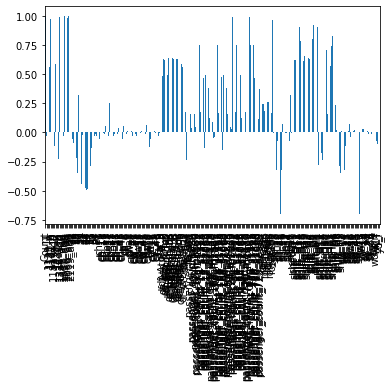

In [291]:
corr['Count'].plot(kind='bar')

In [292]:
from IPython.display import display_html
def display_frames(frames, num_spaces=0):
    t_style = '<table style="display: inline;"'
    tables_html = [df.to_html().replace('<table', t_style)
        for df in frames]
    space = '&nbsp;' * num_spaces
    display_html(space.join(tables_html), raw=True)

In [293]:
#Sort columns by colinearity values
corr.sort_values(['Count'], ascending=False, inplace=True)
corr['Count']

Count       1.000000
2069_add    0.999657
1530_add    0.999300
1387_add    0.998891
2119_add    0.995548
              ...   
45         -0.482188
44         -0.498241
hr_sin     -0.661467
sh_25      -0.699516
sw_7       -0.699516
Name: Count, Length: 261, dtype: float64

In [294]:
#Sort columns by colinearity values
corr.sort_values(['passenger_count_24_s'], ascending=False, inplace=True)
corr['passenger_count_24_s']

passenger_count_24_s     1.000000
passenger_count_12_s     0.999985
passenger_count_168_s    0.999509
passenger_count_720_s    0.997478
Count                    0.991041
                           ...   
42                      -0.458022
44                      -0.477085
hr_sin                  -0.671092
sh_25                   -0.699381
sw_7                    -0.699381
Name: passenger_count_24_s, Length: 261, dtype: float64

### Place some positive and negative correlations to assess

In [295]:
stock_tables = [corr['passenger_count_24_s'][corr.Count>0].to_frame(),corr['passenger_count_24_s'][corr.Count<0].to_frame()]
display_frames(stock_tables)

,passenger_count_24_s
passenger_count_24_s,1.000000
passenger_count_12_s,0.999985
passenger_count_168_s,0.999509
passenger_count_720_s,0.997478
Count,0.991041
1530_add,0.990843
2069_add,0.990685
1387_add,0.989803
2119_add,0.985812
1326_add,0.977787


### Trying to reduce the number of input variables in a dataset with SequentialFeatureSelector

Trying to reduce the number of input variables in order to get rid of multicollinearity

In [299]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [300]:
sfs = SFS(LinearRegression(),
           k_features=11,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

In [269]:
param=[0.7, 0.03, 7, 5, 500, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01]
k_features=10

xgb=XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
print('Start:', datetime.now().strftime("%H:%M:%S"))
for i in range(3):
    k_features=k_features+10*(i)
    sfs = SFS(LinearRegression(),
           k_features=k_features,
           forward=True,
           floating=False,
           scoring = 'neg_mean_absolute_error',
           cv = 0)
    sfs.fit(X_train, y_train)
    #sfs.k_feature_names_     # to get the final set of features
    feat_list=list(sfs.k_feature_names_)
    model = xgb.fit(X_train[feat_list], y_train)
    predictions = model.predict(X_test[feat_list])
    mae = mean_absolute_error(y_test, predictions)
    print(k_features, "MAE: ", mae, datetime.now().strftime("%H:%M:%S"))

Start: 13:34:03
10 MAE:  6.854379679480696 13:34:14



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

20 MAE:  7.8419047143315606 13:34:21



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

40 MAE:  7.089478133681436 13:34:54


#### Optimal number of features

At this stage, I found that the minimum number of features could be 110 with keeping high precision of prediction.

In [306]:
len(feat_list)

110

But, unfortunately, further experiments did not approve that fact

#### Comparison the results of two data filtering methods


- The SequentialFeatureSelector method
- The SelectKBest method

The results are different

In [321]:
num_ts='1180'
data=data_preprocessing_stage_2_2(num_ts,110)
feat_list_2=list(sort(data[0].drop('Count', axis=1).columns))
sravn=sravn.assign(sfs=feat_list)
sravn

,0,sfs
0,1129_n,1530_add
1,1130_n,18
2,1131_n,2069_add
3,1181_n,21
4,1182_add,36
...,...,...
105,sw_14,sy_14
106,sw_28,sy_27
107,sy_14,sy_28
108,sy_27,sy_4


### Feature selection for each of the 6 sub-samples (for forward forecasting  from 1 to 6 days)

In [354]:
print('start', datetime.now().strftime("%H:%M:%S"))

sample_list=[data[1], data[2], 
             data[3], data[4], 
             data[5], data[6]]
sample_param=[[0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 1200, -1, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 1200, -1, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]]
num_features=110
feature_list=[]
n=0
for series_5, param in zip(sample_list, sample_param):
    cols = series_5.columns.drop('Count')
    X = series_5[cols].loc[:'2016.04.30 23:00',:]
    Y=np.array(series_5.loc[:'2016.04.30 23:00','Count']).reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7)
    xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
    eval_set = [(X_test, y_test)]
    xgb.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="mae",
            eval_set=eval_set, verbose=False)
    xgb.get_booster().get_score(importance_type='weight')


    
    dfscores = pd.DataFrame(xgb.feature_importances_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    series=grouped.Count
    grouped=grouped.drop('Count', axis=1)
    grouped=series.to_frame().join(grouped)
    sample_features=grouped.columns
    feature_list.append(sample_features)
    n+=1
    print(n, datetime.now().strftime("%H:%M:%S"))
    
    
    
    
    

start 22:58:19
1 22:59:03
2 23:00:42
3 23:02:09
4 23:05:05
5 23:07:07
6 23:09:26


#### Compare 6 lists of features in one table

In [ ]:
df=df.assign(s3=feature_list[3],s4=feature_list[4], s5=feature_list[5], 
             s1=feature_list[1],s2=feature_list[2], s0=feature_list[0])

In [356]:
df

,0,f1,f2,f3,f4,f5,s3,s4,s5,s1,s2,s0
0,Count,Count,Count,Count,Count,Count,Count,Count,Count,Count,Count,Count
1,1130_n,1130_n,1130_n,1130_n,1129_n,1129_n,1129_n,1181_n,1129_n,1129_n,1129_n,1129_n
2,1131_n,1131_n,1131_n,1181_n,1182_add,1182_add,1130_n,1182_add,1182_add,1130_n,1130_n,1130_n
3,1326_add,1182_add,1326_add,1182_add,1326_add,1229_n,1131_n,13,1334_add,1131_n,1131_n,1131_n
4,1387_add,1326_add,2068_add,1229_n,1334_add,1334_add,1181_n,1334_add,2068_add,1182_add,1182_add,1182_add
...,...,...,...,...,...,...,...,...,...,...,...,...
106,sw_35,sw_49,sw_6,sw_8,sw_9,sw_8,sw_6,trip_distance,trip_distance,sw_4,sw_8,sw_4
107,sw_4,sw_6,sw_7,sw_9,trip_distance,sw_9,sw_8,wd_cos,wd_cos,sw_47,sw_9,sw_41
108,sw_49,sw_7,sw_8,trip_distance,wd_cos,wd_cos,wd_sin,wd_sin,wd_sin,sw_7,wd_cos,sw_49
109,sw_7,sw_8,sw_9,wd_cos,wd_sin,wd_sin,wk_f,wk_f,wk_f,sw_8,wd_sin,sw_7


#### Compare how much features are the same

About 80 features are stable and 30 are variable in each sample

In [372]:
from functools import reduce
columns = [set(df.f1.values),
    set(df.s1.values)]
common_columns_int = list(reduce(lambda a, i: a.intersection(i), columns))
common_columns_int

['df_SBtp_dw_h',
 'shift_H12',
 'ch_23',
 'ch_43',
 'df_EBtp_dw_h',
 'sw_1',
 'shift_H9',
 'cw_28',
 'ch_4',
 'sw_20',
 '1130_n',
 'shift_H2',
 'rol_24s',
 'df_NBtp_dw_h',
 'df_WBtp_h_qs',
 'sw_7',
 'sh_11',
 'passenger_count_24_s1334',
 'cw_49',
 'sh_2',
 'sh_25',
 'sh_10',
 'passenger_count_168_s1334',
 'cw_41',
 'passenger_count_24_s',
 'passenger_count_12_s',
 'hr_sin',
 'sh_43',
 'df_Atp_dw_h',
 'shift_H14',
 'cw_1',
 'shift_H11',
 'ch_47',
 '1326_add',
 'sh_29',
 '2068_add',
 'shift_H13',
 'shift_H8',
 '2069_add',
 'sw_15',
 'shift_H17',
 'sw_29',
 'sh_39',
 'df_WBtp_dw_h',
 'cw_34',
 'passenger_count_720_s1334',
 'dw_m_3',
 '1530_add',
 'passenger_count_12_s1334',
 'sh_15',
 'sh_1',
 'passenger_count_720_s',
 '2119_add',
 'shift_H15',
 'rol_12m',
 'passenger_count_168_s',
 'shift_H10',
 'shift_H23',
 'df_Atp_h_ms',
 'cw_7',
 'ch_5',
 'sw_27',
 'ch_49',
 'sw_14',
 'sw_8',
 '49',
 'df_EBtp_h_ms',
 'sh_19',
 'ch_19',
 'sw_4',
 'passenger_count_24_s1182',
 'sh_23',
 'cw_13',
 'dw_h_

In [373]:
len(common_columns_int)

86

In [352]:
common_columns_un = list(reduce(lambda a, i: a.union(i), columns))
common_columns_un

['cw_8',
 'ch_1',
 'shift_H21',
 'sh_5',
 'ch_43',
 'shift_D1',
 '1229_n',
 'sh_9',
 'sw_9',
 'passenger_count_168_s1326',
 'cw_28',
 'ch_4',
 'sh_31',
 'cw_14',
 'sw_20',
 'shift_H16',
 'cw_23',
 'ch_21',
 'cw_43',
 '1130_n',
 'cw_15',
 'sw_11',
 'rol_24s',
 'sh_26',
 'sh_14',
 'after_hol',
 'ch_2',
 'df_WBtp_h_qs',
 'sh_11',
 'sh_20',
 'sw_47',
 'ch_31',
 'sh_10',
 'sh_25',
 'passenger_count_168_s1334',
 '1129_n',
 'passenger_count_24_s',
 'cw_45',
 'passenger_count_720_s1326',
 'ch_37',
 'ch_33',
 'cw_1',
 'ch_47',
 'cw_9',
 'shift_H8',
 'sw_15',
 'ch_44',
 'sh_37',
 'shift_H19',
 'df_WBtp_dw_h',
 'cw_34',
 '1181_n',
 'passenger_count_720_s1334',
 '1530_add',
 'passenger_count_12_s1334',
 'sh_15',
 'sh_1',
 'ch_50',
 'sw_16',
 '2119_add',
 'shift_H10',
 'passenger_count_168_s',
 'sw_39',
 'd_h_3',
 'sh_4',
 'shift_H23',
 'df_Atp_h_ms',
 'rol_720s',
 'y_f',
 'wd_sin',
 'cw_7',
 'ch_49',
 'df_EBtp_h_ms',
 '49',
 'sh_3',
 'ch_29',
 'ch_19',
 'sw_4',
 'VendorID',
 '38',
 'sw_17',
 'ch_4

In [353]:
len(common_columns_un)

226

But this way also does not get good results but only makes the calculations longer

## Sequential feature selection

At this point, I started adding new feature sets to the old data sequentially, removing the worsening result, leaving the improving ones.

I used 2 models: 
    - the model from previous step with filtering features one time
    - the model with filtering features one time separately for each of the 6 sub-samples with interruption 
    
You can see the results in the table:

In [14]:
pd.read_excel('table_2.xlsx')

,Features,m1_may,m1_2may,m2_may,m1_june,m1_2june,m2_june
0,Without adding,14.35,.,14.46,12.73,.,12.86
1,old+traffic,14.26,.,14.47,12.64,.,12.85
2,old+traffic+raw,13.72,123,13.95,12.58,117,12.69
3,old+traffic+raw+cluster,13.63,.,.,12.78,.,.
4,old+traffic+raw+heat,.,.,15.28,.,.,14.13
5,old+traffic+raw+neighbor,.,.,13.72,.,.,12.72


where
- m1 - the old model with adding new features after feature selection
- m1_2 - the old model with adding new features before feature selection
- m2 - with filtering features one time separately for each of the 6 sub-samples with interruption 

The table shows that adding new features from the old+traffic series clearly improves the test results. So I decided to train two models in parallel with adding only them.

# Model m1

In [ ]:
def calculate_regression_ts(num_ts, sample_param):
    
    data=data_preprocessing_stage_2(num_ts,160)
    models=[]
    
    warnings.filterwarnings('ignore')
    train_samples=[data[1], data[2], data[3], data[4], data[5], data[6]]
    for param, train_sample in zip(sample_param, train_samples ):
        
        train_data_m=train_sample[:"2016-05-31 23:00"] # обучаю все модели на всех выборках только до конца мая включительно
                                                       # месяц июнь вообще не трогаю
            
        X=np.array(train_data_m.iloc[:,1:])
        Y=np.array(train_data_m.iloc[:,:1]).reshape(-1)
        xgb = XGBRegressor(
            colsample_bytree=param[0],
            learning_rate=param[1],
            max_depth=param[2],
            min_child_weight=param[3],
            n_estimators=param[4],
            nthread=param[5],
            objective=param[6],
            silent=param[7],
            subsample=param[8],
            gamma=param[9],
            reg_alpha=param[10],
            reg_lambda=param[11])
        xgb.fit(X,Y)
        models.append(xgb)
        
    
    warnings.filterwarnings('default')
    
    # здесь задаю границы тестовых выборок
    period_may=pd.date_range(start="2016-04-30 23:00",end="2016-05-31 17:00", freq='H')
    period_june=pd.date_range(start="'2016-05-31 23:00'",end="2016-06-30 17:00", freq='H')
    
    res_pred_m=0
   
    res_pred_j=0
    
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in period_may:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_m += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_m)
       
    ts_Q_may=res_pred_m
    
    for t in period_june:
        predicted=[]
        actuals=[]
        for i in range(6):
            x=np.array(data[i+1][t:t].iloc[:,1:])
            pred=models[i].predict(x)
            actual=data[i+1][t:t].Count
            predicted.append(pred[0])
            actuals.append(actual[0])
        res_pred_j += (np.abs(np.array(actuals) - np.array(predicted))).sum()/6
        
        #print(res_pred_j)
        
        idx=num_ts+'_'+pd.Index([data[1][t:t].index[0].strftime("%Y-%m-%d")]*6)+'_'+str(data[1][t:t].index[0].hour)+num_str
        
        series_=pd.Series(predicted ,index=idx)
        series=series.append(series_)
    ts_Q_june=res_pred_j
    
        
        
    
    return ts_Q_may, ts_Q_june, series, predicted, models

## ошибка за май
Q_may1=0
## ошибка за июнь
Q_june1=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer1=pd.Series(dtype='int')
ts_list=col_list
sample_param=[[0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1e-05, 0.01],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1e-05],
 [0.7, 0.03, 7, 3, 500, 4, 'reg:linear', 1, 0.7, 0.0, 1, 1],
 [0.7, 0.03, 7, 5, 500, 4, 'reg:linear', 1, 0.7, 0.3, 0.1, 0.1]] # пробую поменять эти параметры

n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
for num_ts in ts_list:
    warnings.simplefilter('ignore')
    
    ts_Q_may, ts_Q_june, series, predicted, models =calculate_regression_ts(num_ts,sample_param)
    Q_may1+=ts_Q_may
    Q_june1+=ts_Q_june
    
    answer1=answer1.append(series)
        
    print('Посчитан ряд ',num_ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))

answer1.index.name='id'
answer1.name='y'    


print('The end', datetime.now().strftime("%H:%M:%S"))

print(answer1.head())

In [16]:
print('Ошибка за май: ',Q_may1/(102*739))
print('Ошибка за июнь: ',Q_june1/(102*715))

Ошибка за май:  9.030986255957583
Ошибка за июнь:  14.665555842770884


In [15]:
answer1.to_csv('submission5_reg.csv', sep = ',')

In [17]:
!kaggle competitions submit -c yellowtaxi -f submission5_reg.csv -m regr_add_traffic_raw

Successfully submitted to Жёлтое такси



  0%|          | 0.00/16.6M [00:00<?, ?B/s]
  0%|          | 80.0k/16.6M [00:00<00:23, 747kB/s]
  5%|4         | 808k/16.6M [00:00<00:16, 1.02MB/s]
 11%|#         | 1.77M/16.6M [00:00<00:11, 1.40MB/s]
 13%|#3        | 2.22M/16.6M [00:01<00:16, 940kB/s] 
 20%|#9        | 3.27M/16.6M [00:01<00:10, 1.29MB/s]
 27%|##6       | 4.44M/16.6M [00:01<00:07, 1.77MB/s]
 36%|###6      | 5.98M/16.6M [00:01<00:04, 2.41MB/s]
 43%|####3     | 7.16M/16.6M [00:01<00:03, 3.18MB/s]
 50%|####9     | 8.24M/16.6M [00:01<00:02, 4.05MB/s]
 56%|#####6    | 9.38M/16.6M [00:01<00:01, 5.04MB/s]
 63%|######3   | 10.5M/16.6M [00:01<00:01, 6.07MB/s]
 70%|######9   | 11.6M/16.6M [00:02<00:00, 6.86MB/s]
 77%|#######7  | 12.8M/16.6M [00:02<00:00, 7.98MB/s]
 84%|########3 | 13.9M/16.6M [00:02<00:00, 8.78MB/s]
 91%|######### | 15.1M/16.6M [00:02<00:00, 9.54MB/s]
 98%|#########7| 16.2M/16.6M [00:02<00:00, 10.2MB/s]
100%|##########| 16.6M/16.6M [00:05<00:00, 3.32MB/s]


In [18]:
!kaggle competitions submissions yellowtaxi

fileName             date                 description           status    publicScore  privateScore  
-------------------  -------------------  --------------------  --------  -----------  ------------  
submission5_reg.csv  2020-06-01 14:07:30  regr_add_traffic_raw  complete  14.66554     14.66554      
submission5_reg.csv  2020-06-01 13:31:23  regr_add_traffic_raw  complete  14.66554     14.66554      
submission4_reg.csv  2020-05-25 03:29:21  regr4                 complete  15.05690     15.05690      
submission3_reg.csv  2020-05-24 04:42:08  regr2                 complete  9.08324      9.08324       
submission2_reg.csv  2020-05-23 02:38:50  regr                  complete  9.07267      9.07267       
submission.csv       2020-05-18 05:14:50  SARIMAX               complete  37.19871     37.19871      
submission.csv       2020-05-18 05:10:17  xgb                   complete  37.19871     37.19871      
answer.csv           2020-05-17 10:40:27  None                  complete  37.19491

The previous result was improved with score is 14.66